# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/GEANT-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'TCN'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'TCN_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'TCN_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time  OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2005-05-04-15-30     0.0  16760.79111  12407.777780  10453.848890   
1  2005-05-04-15-45     0.0  16346.46222   9373.208889   8439.048889   
2  2005-05-04-16-00     0.0  16755.22667  10638.302220  12623.520000   
3  2005-05-04-16-15     0.0  18488.00889  12263.697780  13389.128890   
4  2005-05-04-16-30     0.0  13748.27556  11323.333330  14048.426670   

        OD_1-5       OD_1-6       OD_1-7       OD_1-8       OD_1-9  ...  \
0  1468.631111  4768.444444  25290.37333  2468.515556  7984.213333  ...   
1  1032.906667  1649.520000  14433.05778  3182.986667  7243.173333  ...   
2   721.226667  1693.057778  17066.67556  5304.195556  6696.844444  ...   
3   995.600000  2984.231111  13325.22667  6248.248889  5719.804444  ...   
4   804.044444  2698.124444  16651.25333  5761.528889  5088.204444  ...   

   OD_23-14    OD_23-15     OD_23-16     OD_23-17     OD_23-18     OD_23-19  \
0       0.0  211.395556  1212.666667  1026.391111  51508.78222  1488.951111   
1       0.0  190.142222  1079.751111   529.617778  44913.43111  1410.400000   
2       0.0   51.048889  1750.631111    81.760000  47603.85778  1016.977778   
3       0.0  217.911111  3313.120000   356.000000  47023.99111  1092.017778   
4       0.0  292.071111  4479.644444   541.288889  47737.10222  1139.217778   

      OD_23-20     OD_23-21   OD_23-22  OD_23-23  
0  175293.2444  3247.164444  14.106667       0.0  
1  148162.8711  3669.173333   6.880000       0.0  
2  154312.8711  3452.320000  24.488889       0.0  
3  148199.6622  3300.613333  36.951111       0.0  
4  147601.5467  4073.137778  59.848889       0.0  

[5 rows x 530 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('15T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2005-08-02 09:30:00', freq='15T')

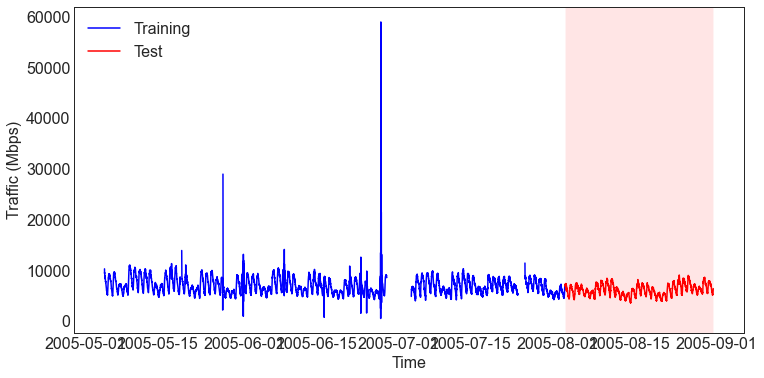

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

4.931113265982958


In [26]:
print(np.min(data.flatten()))

-0.003975552580138194


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

10769


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(10759, 10, 529)

In [32]:
y_data.shape

(10759, 1, 529)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(10759, 529)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

8606

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6884

In [40]:
valid_length

1722

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6884, 529, 10)

In [43]:
y_train.shape

(6884, 529)

In [44]:
X_valid.shape

(1722, 529, 10)

In [45]:
y_valid.shape

(1722, 529)

In [46]:
X_test.shape

(2153, 529, 10)

In [47]:
y_test.shape

(2153, 529)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(8606, 529, 10)

In [50]:
y.shape

(8606, 529)

In [51]:
splits

((#6884) [0,1,2,3,4,5,6,7,8,9...],
 (#1722) [6884,6885,6886,6887,6888,6889,6890,6891,6892,6893...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#8606) [(TSTensor(vars:529, len:10), tensor([0.0000e+00, 8.9423e-02, 3.7106e-01, 1.0264e-01, 7.2026e-02, 3.4304e-03,
        7.1890e-02, 1.2682e-02, 2.5281e-02, 9.1491e-03, 5.0183e-03, 1.2151e-01,
        0.0000e+00, 5.6280e-05, 1.8669e-02, 3.2046e-01, 3.0214e-02, 4.0630e-01,
        5.0114e-02, 6.6921e-02, 1.0054e-04, 0.0000e+00, 2.1455e-01, 0.0000e+00,
        7.3656e-01, 2.4451e-03, 1.4999e-02, 9.5933e-04, 1.4186e-01, 9.6139e-03,
        7.5581e-03, 5.6137e-01, 1.3439e-03, 7.8781e-03, 4.1034e-02, 1.0031e-02,
        5.2605e-03, 3.9400e-03, 5.2090e-02, 4.1799e-03, 2.3216e-02, 6.7784e-02,
        3.5897e-02, 1.7727e-01, 4.3577e-03, 5.7287e-01, 0.0000e+00, 7.6272e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0254e-04, 6.5089e-03, 1.7143e-03,
        1.1740e-01, 4.1891e-02, 7.4133e-03, 1.8199e-02, 1.3436e-02, 1.7860e-04,
        1.5109e-02, 1.5142e-02, 7.8321e-04, 1.5964e-02, 9.8029e-04, 2.2297e-02,
        8.7682e-02, 7.0101e-04, 8.7537e-03, 0.0000e+00, 2.1880e-01, 0.0000e+00,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "layers": hp.choice('layers', [[25, 25, 25, 25, 25, 25, 25, 25], [25, 25, 25, 25, 25, 25], [25, 25, 25, 25]]),
    "ks": hp.choice('ks', [7, 5, 3]),
    "conv_dropout": hp.choice('conv_dropout', [0.0, 0.1, 0.2, 0.5])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x20a4a616248>,
 'lr': <hyperopt.pyll.base.Apply at 0x20a4a629c08>,
 'epochs': <hyperopt.pyll.base.Apply at 0x20a4a629a08>,
 'patience': <hyperopt.pyll.base.Apply at 0x20a4a6299c8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x20a4a819388>,
 'layers': <hyperopt.pyll.base.Apply at 0x20a4a72c048>,
 'ks': <hyperopt.pyll.base.Apply at 0x20a4a72cac8>,
 'conv_dropout': <hyperopt.pyll.base.Apply at 0x20a4a72cfc8>}

In [55]:
# clear memory 
gc.collect()

40

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TCN
        k = {
            'layers': params['layers'],
            'ks': params['ks'],
            'conv_dropout': params['conv_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
  0%|                                                                          | 0/100 [00:02<?, ?trial/s, best loss=?]

No improvement since epoch 23: early stopping                                                                          
  0%|                                                                          | 0/100 [01:22<?, ?trial/s, best loss=?]

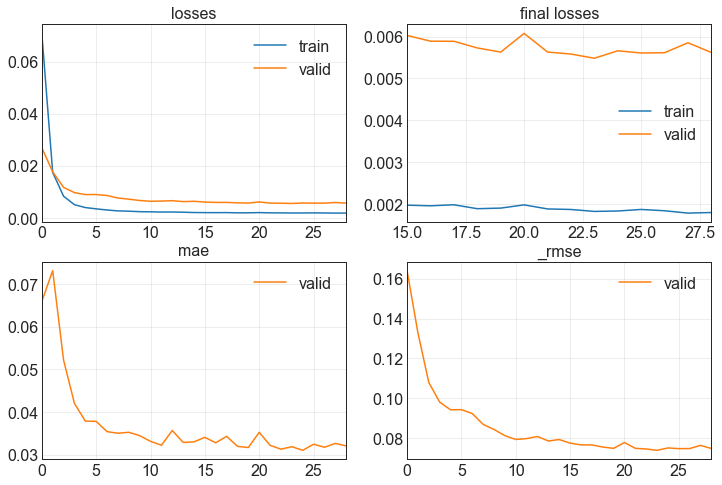

80.11557269096375                                                                                                      
[0.0017939922399818897, 0.005620368290692568, 0.032032568007707596, 0.07496911287307739]                               
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
  1%|▍                                           | 1/100 [01:24<2:16:58, 83.01s/trial, best loss: 0.005620368290692568]

No improvement since epoch 24: early stopping                                                                          
  1%|▍                                           | 1/100 [01:50<2:16:58, 83.01s/trial, best loss: 0.005620368290692568]

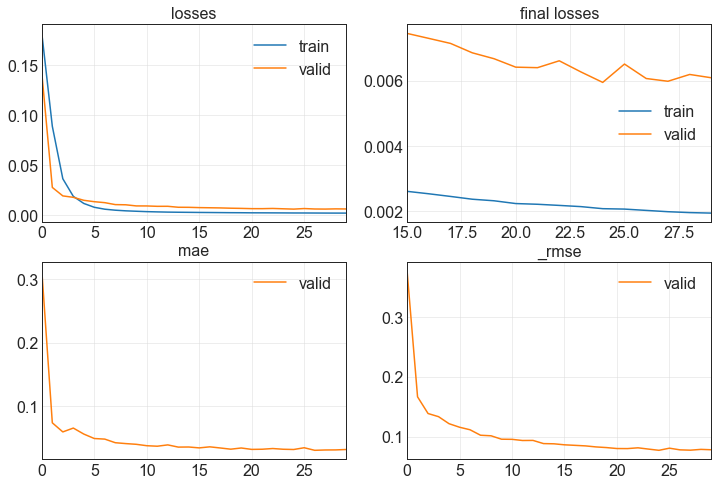

26.360270261764526                                                                                                     
[0.001945970463566482, 0.0060896738432347775, 0.031699519604444504, 0.0780363604426384]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
  2%|▉                                           | 2/100 [01:52<1:48:32, 66.45s/trial, best loss: 0.005620368290692568]

No improvement since epoch 37: early stopping                                                                          
  2%|▉                                           | 2/100 [05:06<1:48:32, 66.45s/trial, best loss: 0.005620368290692568]

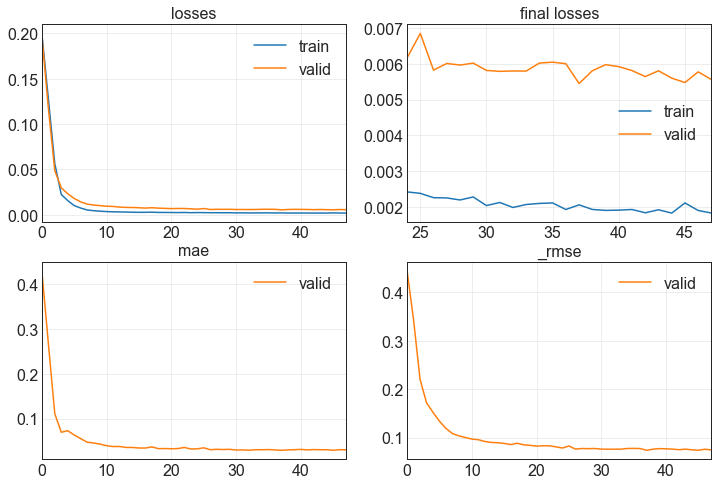

194.30463409423828                                                                                                     
[0.0018279944779351354, 0.005562430247664452, 0.03024469129741192, 0.07458170503377914]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
  3%|█▎                                         | 3/100 [05:07<2:50:07, 105.23s/trial, best loss: 0.005562430247664452]

No improvement since epoch 7: early stopping                                                                           
  3%|█▎                                         | 3/100 [05:41<2:50:07, 105.23s/trial, best loss: 0.005562430247664452]

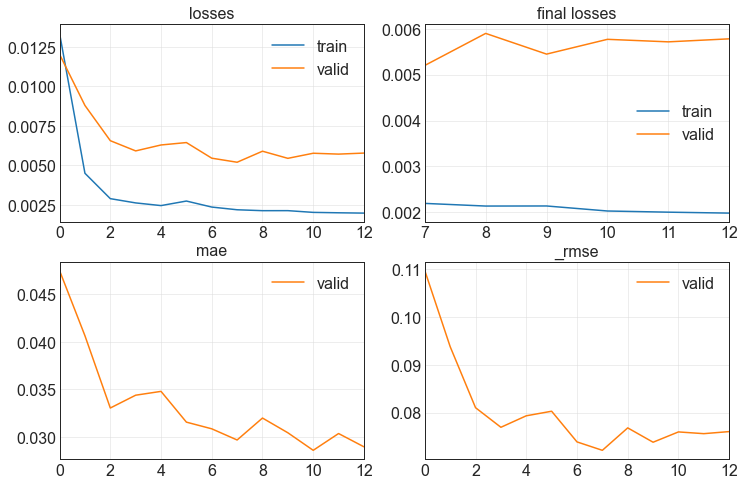

34.43825340270996                                                                                                      
[0.0019807973876595497, 0.005782785825431347, 0.02897057496011257, 0.07604463398456573]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
  4%|█▊                                          | 4/100 [05:43<2:15:04, 84.42s/trial, best loss: 0.005562430247664452]

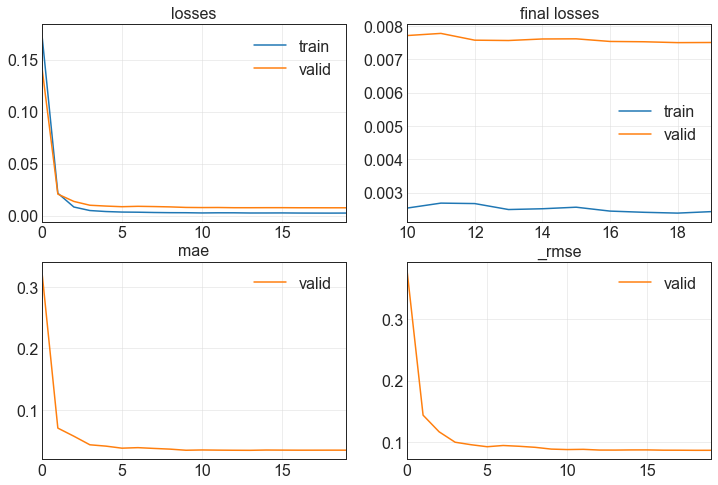

60.696871757507324                                                                                                     
[0.002432020613923669, 0.007506789639592171, 0.0341157466173172, 0.08664173632860184]                                  
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
  5%|██▏                                         | 5/100 [06:45<2:03:03, 77.72s/trial, best loss: 0.005562430247664452]

No improvement since epoch 17: early stopping                                                                          
  5%|██▏                                         | 5/100 [11:28<2:03:03, 77.72s/trial, best loss: 0.005562430247664452]

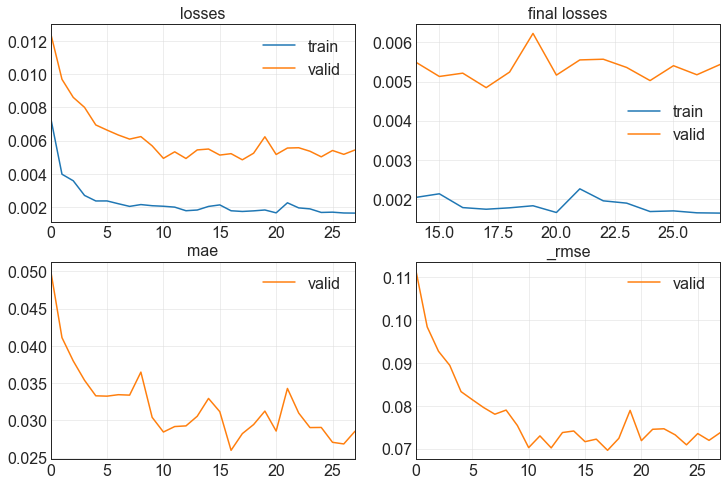

283.1850280761719                                                                                                      
[0.0016360983718186617, 0.005437345243990421, 0.028546687215566635, 0.07373835891485214]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
  6%|██▌                                        | 6/100 [11:30<3:39:00, 139.79s/trial, best loss: 0.005437345243990421]

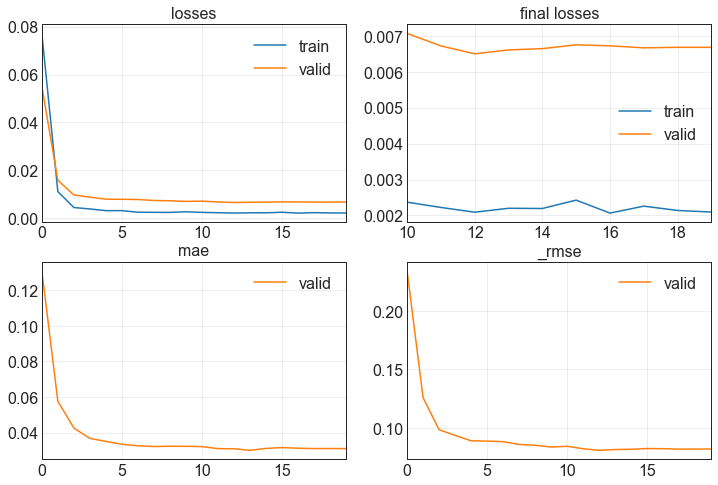

204.78992462158203                                                                                                     
[0.0020933649502694607, 0.006681459955871105, 0.030986810103058815, 0.08174020051956177]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
  7%|███                                        | 7/100 [14:56<4:07:33, 159.72s/trial, best loss: 0.005437345243990421]

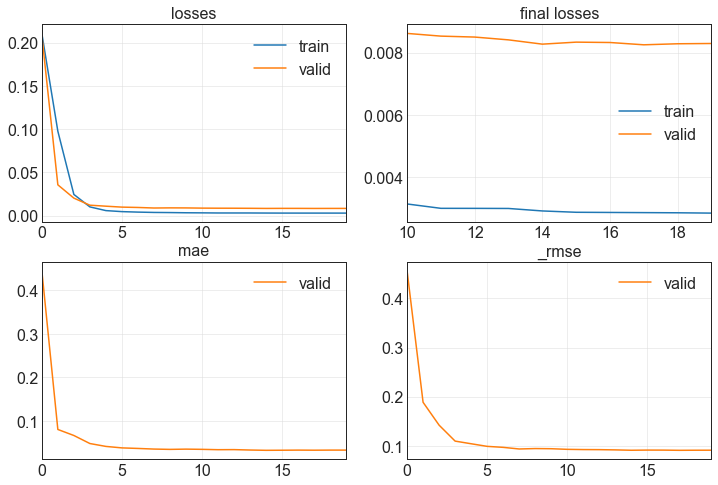

42.50824999809265                                                                                                      
[0.002858940279111266, 0.008293131366372108, 0.03386808559298515, 0.0910666286945343]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
  8%|███▍                                       | 8/100 [15:40<3:11:38, 124.98s/trial, best loss: 0.005437345243990421]

No improvement since epoch 29: early stopping                                                                          
  8%|███▍                                       | 8/100 [19:05<3:11:38, 124.98s/trial, best loss: 0.005437345243990421]

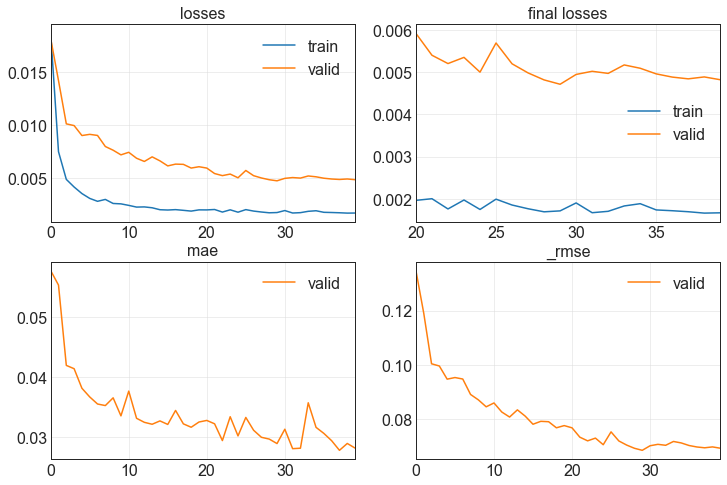

204.89575672149658                                                                                                     
[0.001666664145886898, 0.004819139838218689, 0.028202181681990623, 0.06942002475261688]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
  9%|███▊                                       | 9/100 [19:07<3:46:33, 149.38s/trial, best loss: 0.004819139838218689]

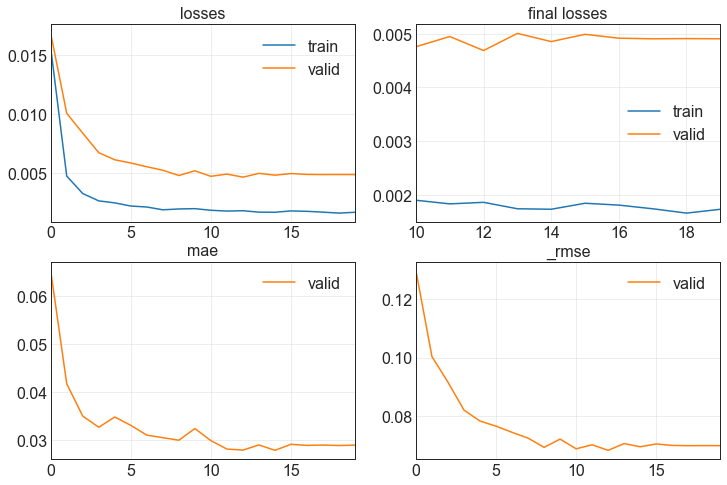

106.02933478355408                                                                                                     
[0.001729818875901401, 0.004905664827674627, 0.028963901102542877, 0.07004044204950333]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 10%|████▏                                     | 10/100 [20:54<3:25:15, 136.84s/trial, best loss: 0.004819139838218689]

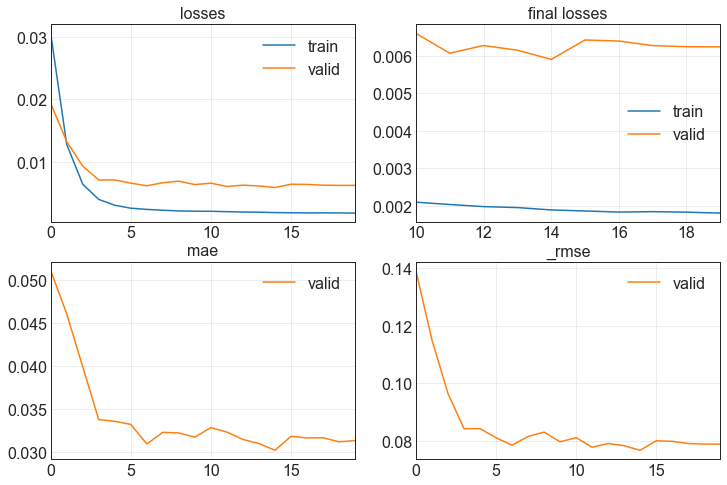

28.615999698638916                                                                                                     
[0.0018040203722193837, 0.00623697554692626, 0.031345851719379425, 0.07897453010082245]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 11%|████▌                                     | 11/100 [21:24<2:35:28, 104.81s/trial, best loss: 0.004819139838218689]

No improvement since epoch 29: early stopping                                                                          
 11%|████▌                                     | 11/100 [23:30<2:35:28, 104.81s/trial, best loss: 0.004819139838218689]

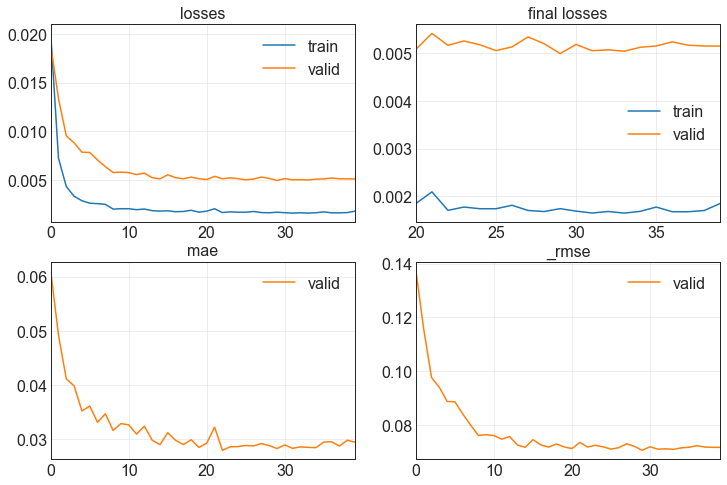

125.95074653625488                                                                                                     
[0.0018527349457144737, 0.005147234536707401, 0.029445882886648178, 0.07174423336982727]                               
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 12%|█████                                     | 12/100 [23:32<2:43:40, 111.60s/trial, best loss: 0.004819139838218689]

No improvement since epoch 15: early stopping                                                                          
 12%|█████                                     | 12/100 [23:56<2:43:40, 111.60s/trial, best loss: 0.004819139838218689]

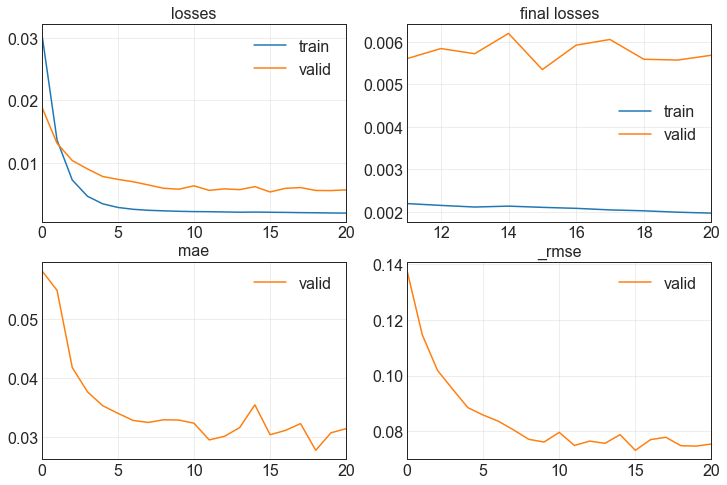

25.063302993774414                                                                                                     
[0.0019707651808857918, 0.005687905941158533, 0.03145840764045715, 0.07541820406913757]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 13%|█████▌                                     | 13/100 [23:58<2:04:48, 86.08s/trial, best loss: 0.004819139838218689]

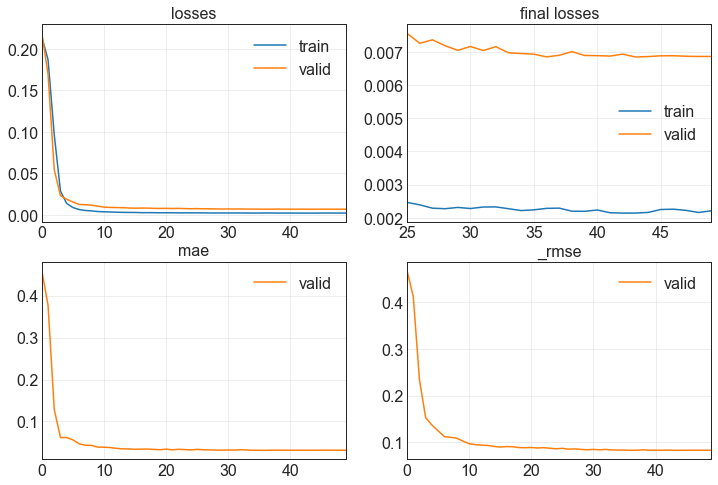

109.5991461277008                                                                                                      
[0.002213614759966731, 0.006859510205686092, 0.03163079917430878, 0.08282215893268585]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 14%|██████                                     | 14/100 [25:49<2:14:10, 93.62s/trial, best loss: 0.004819139838218689]

No improvement since epoch 27: early stopping                                                                          
 14%|██████                                     | 14/100 [28:11<2:14:10, 93.62s/trial, best loss: 0.004819139838218689]

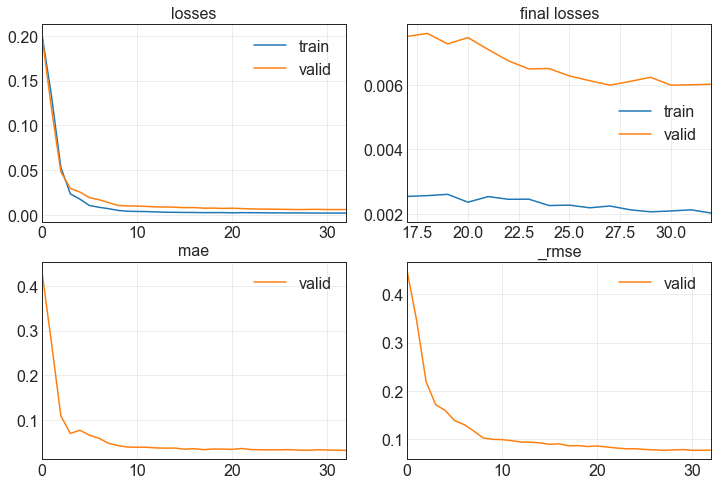

142.3554608821869                                                                                                      
[0.0020216696429997683, 0.006021823268383741, 0.03171780705451965, 0.0776004046201706]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 15%|██████▎                                   | 15/100 [28:13<2:33:57, 108.68s/trial, best loss: 0.004819139838218689]

No improvement since epoch 25: early stopping                                                                          
 15%|██████▎                                   | 15/100 [30:44<2:33:57, 108.68s/trial, best loss: 0.004819139838218689]

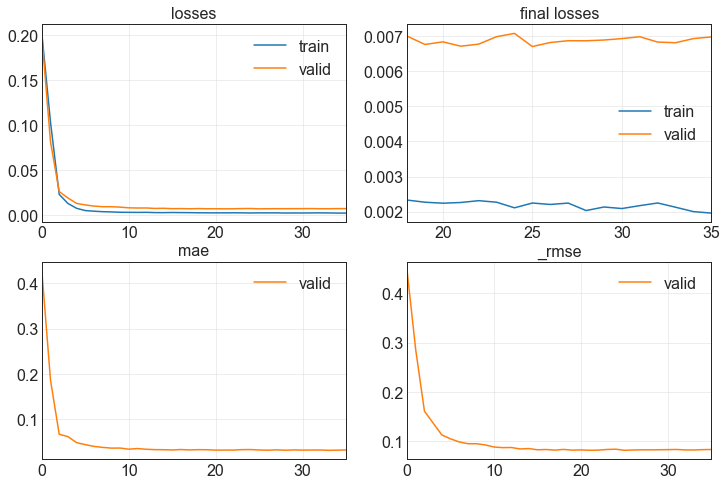

150.82209634780884                                                                                                     
[0.001957123400643468, 0.006981767248362303, 0.03195064887404442, 0.08355697244405746]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 16%|██████▋                                   | 16/100 [30:45<2:50:28, 121.77s/trial, best loss: 0.004819139838218689]

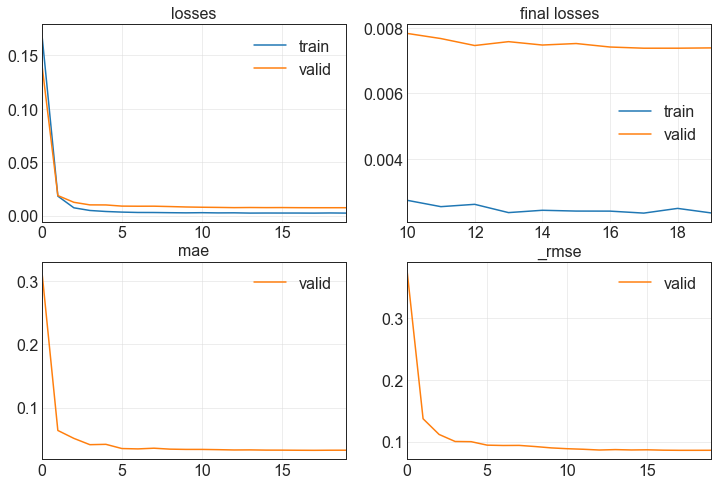

103.06257557868958                                                                                                     
[0.002340882085263729, 0.007391572929918766, 0.03259975463151932, 0.08597425371408463]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 17%|███████▏                                  | 17/100 [32:30<2:41:16, 116.59s/trial, best loss: 0.004819139838218689]

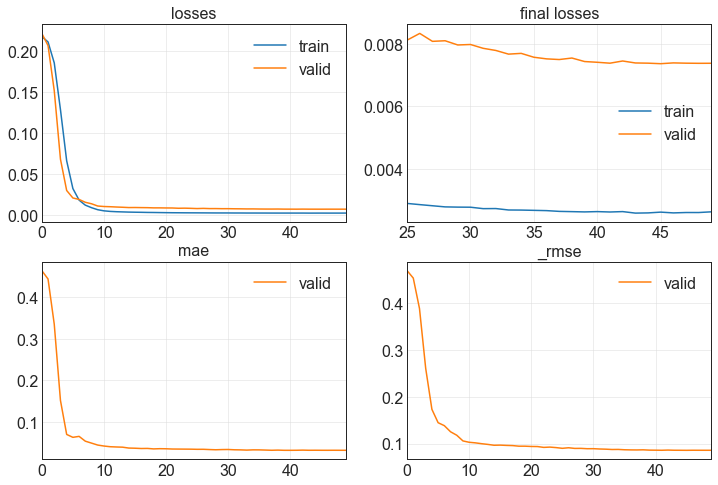

57.07898211479187                                                                                                      
[0.0026295764837414026, 0.007380038499832153, 0.03242381662130356, 0.08590714633464813]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 18%|███████▋                                   | 18/100 [33:29<2:15:31, 99.17s/trial, best loss: 0.004819139838218689]

No improvement since epoch 6: early stopping                                                                           
 18%|███████▋                                   | 18/100 [33:54<2:15:31, 99.17s/trial, best loss: 0.004819139838218689]

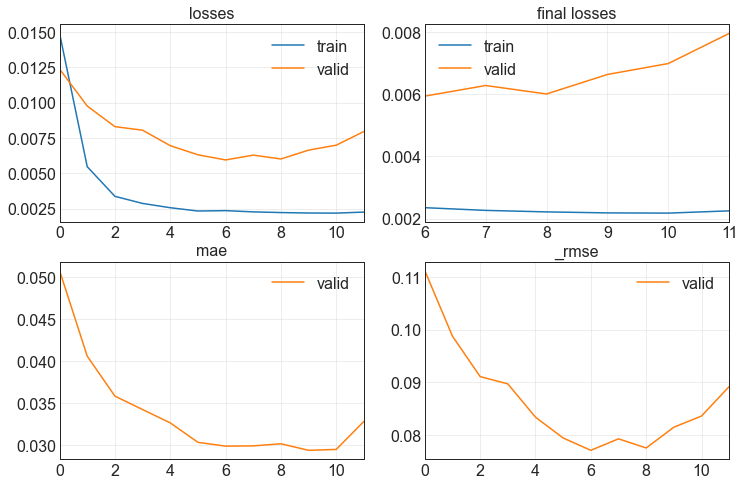

26.14168095588684                                                                                                      
[0.002249735174700618, 0.007952109910547733, 0.0328078493475914, 0.08917459100484848]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 19%|████████▏                                  | 19/100 [33:56<1:44:56, 77.73s/trial, best loss: 0.004819139838218689]

No improvement since epoch 10: early stopping                                                                          
 19%|████████▏                                  | 19/100 [34:18<1:44:56, 77.73s/trial, best loss: 0.004819139838218689]

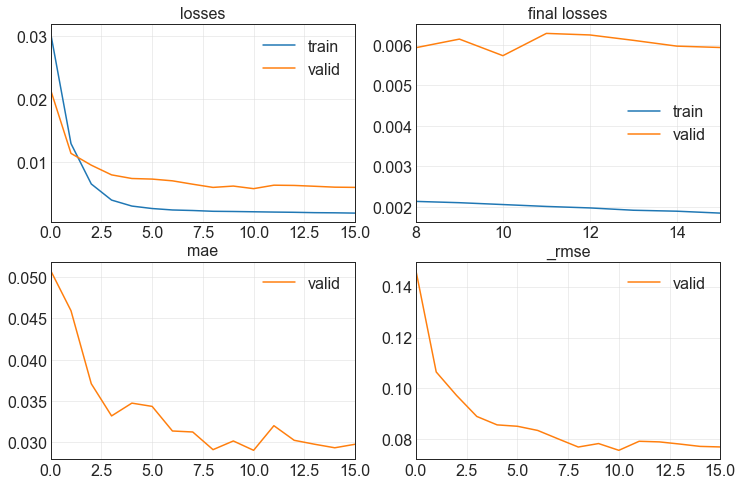

22.523210525512695                                                                                                     
[0.00184812827501446, 0.005935624707490206, 0.02977830171585083, 0.07704301178455353]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 20%|████████▌                                  | 20/100 [34:20<1:22:08, 61.60s/trial, best loss: 0.004819139838218689]

No improvement since epoch 30: early stopping                                                                          
 20%|████████▌                                  | 20/100 [37:47<1:22:08, 61.60s/trial, best loss: 0.004819139838218689]

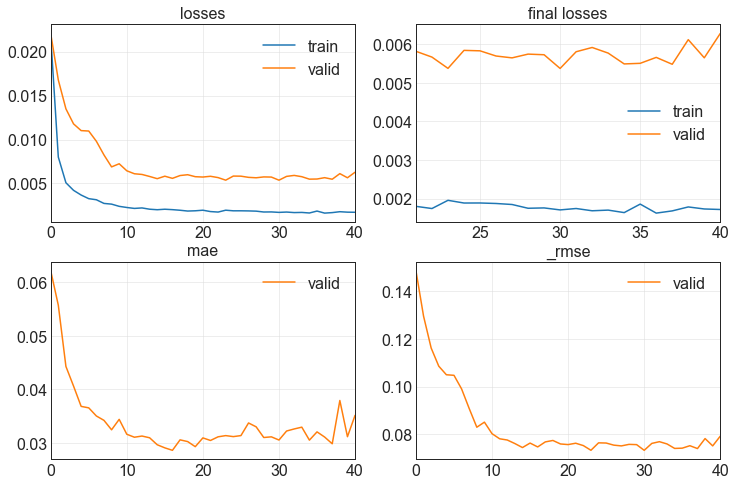

207.58833289146423                                                                                                     
[0.001716700498946011, 0.006278745364397764, 0.035153619945049286, 0.07923852652311325]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 21%|████████▊                                 | 21/100 [37:49<2:19:20, 105.83s/trial, best loss: 0.004819139838218689]

No improvement since epoch 19: early stopping                                                                          
 21%|████████▊                                 | 21/100 [40:23<2:19:20, 105.83s/trial, best loss: 0.004819139838218689]

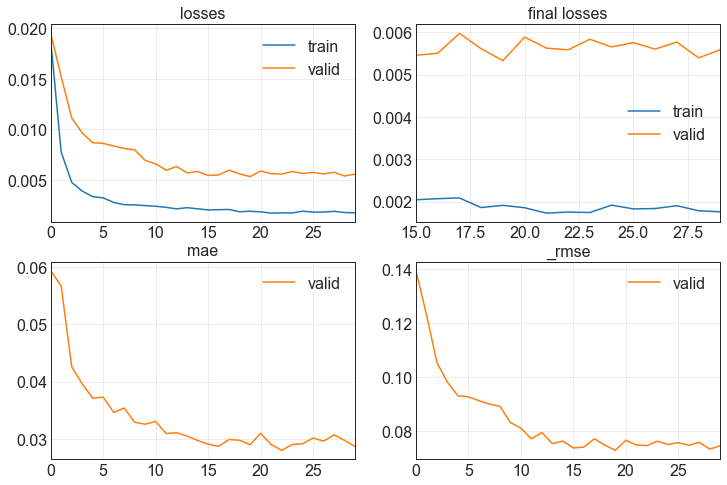

154.69156193733215                                                                                                     
[0.0017573749646544456, 0.005584203638136387, 0.028710709884762764, 0.07472752034664154]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 22%|█████████▏                                | 22/100 [40:25<2:37:11, 120.92s/trial, best loss: 0.004819139838218689]

No improvement since epoch 38: early stopping                                                                          
 22%|█████████▏                                | 22/100 [44:42<2:37:11, 120.92s/trial, best loss: 0.004819139838218689]

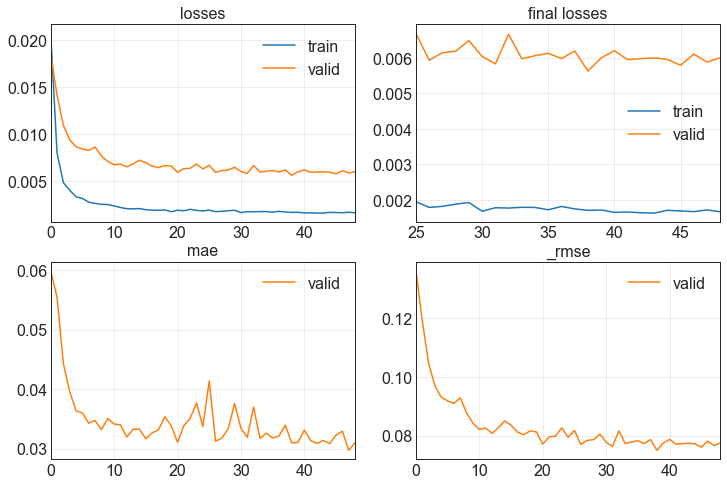

257.5514450073242                                                                                                      
[0.001660678070038557, 0.006008132826536894, 0.031018070876598358, 0.07751213759183884]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 23%|█████████▋                                | 23/100 [44:44<3:28:22, 162.37s/trial, best loss: 0.004819139838218689]

No improvement since epoch 26: early stopping                                                                          
 23%|█████████▋                                | 23/100 [51:10<3:28:22, 162.37s/trial, best loss: 0.004819139838218689]

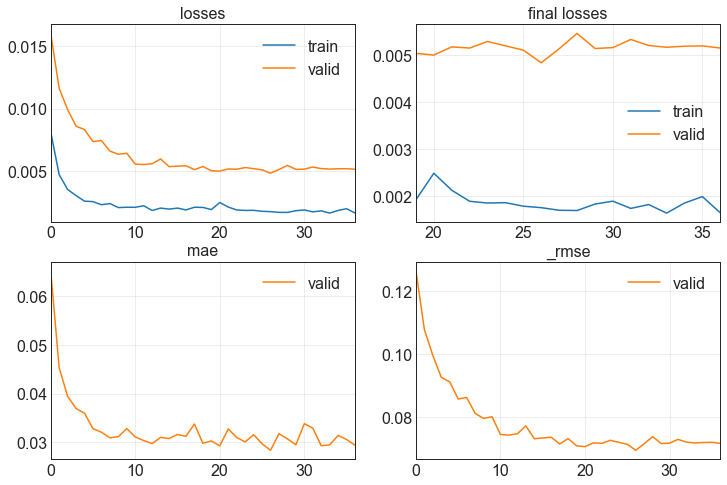

386.24202585220337                                                                                                     
[0.0016437039012089372, 0.005147410091012716, 0.029376167804002762, 0.07174544781446457]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 24%|██████████                                | 24/100 [51:12<4:51:17, 229.97s/trial, best loss: 0.004819139838218689]

No improvement since epoch 42: early stopping                                                                          
 24%|██████████                                | 24/100 [53:55<4:51:17, 229.97s/trial, best loss: 0.004819139838218689]

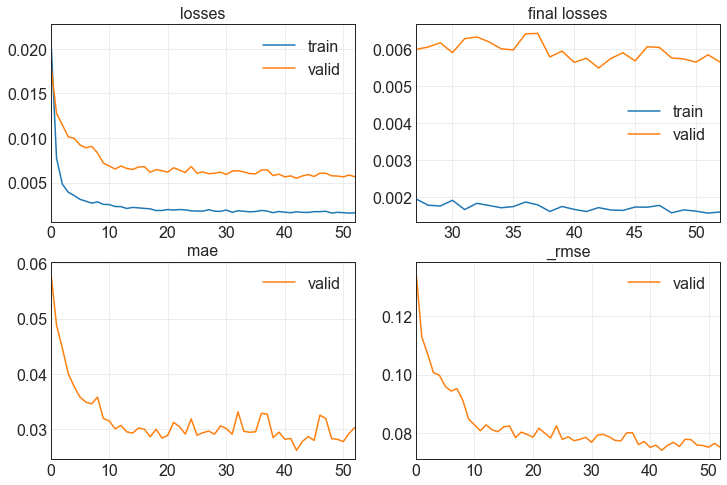

163.09758234024048                                                                                                     
[0.0016032882267609239, 0.005641758907586336, 0.03031291998922825, 0.07511163502931595]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 25%|██████████▌                               | 25/100 [53:57<4:22:58, 210.38s/trial, best loss: 0.004819139838218689]

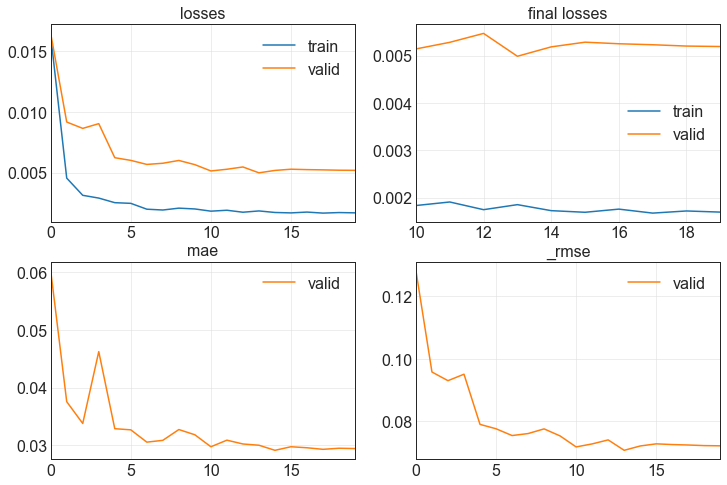

104.52077865600586                                                                                                     
[0.00169530906714499, 0.005193004384636879, 0.029453450813889503, 0.07206250727176666]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 26%|██████████▉                               | 26/100 [55:43<3:40:50, 179.06s/trial, best loss: 0.004819139838218689]

No improvement since epoch 12: early stopping                                                                          
 26%|██████████▉                               | 26/100 [59:42<3:40:50, 179.06s/trial, best loss: 0.004819139838218689]

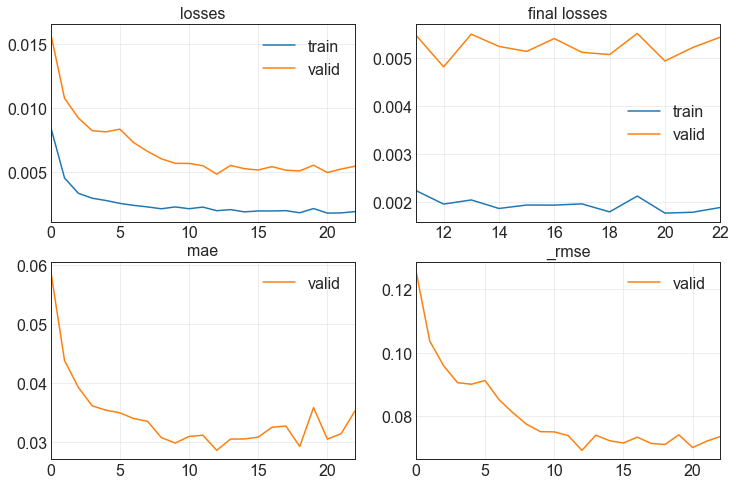

239.30034494400024                                                                                                     
[0.001881093136034906, 0.005433716345578432, 0.035266194492578506, 0.0737137421965599]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 27%|███████████▎                              | 27/100 [59:43<4:00:22, 197.57s/trial, best loss: 0.004819139838218689]

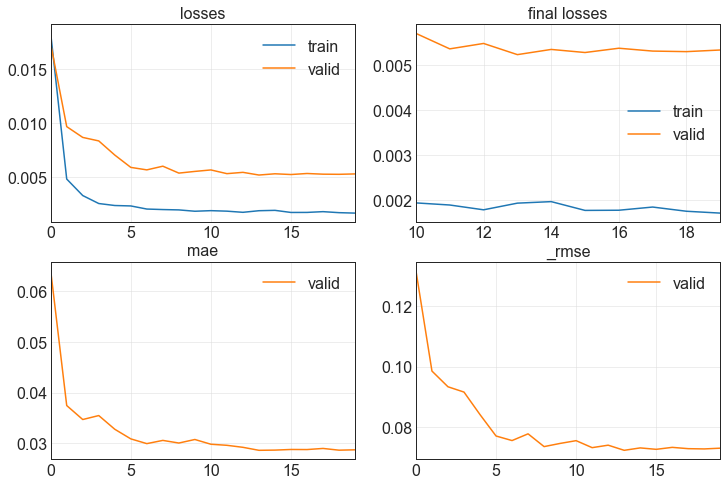

104.52810645103455                                                                                                     
[0.0017026016721501946, 0.005328319501131773, 0.028728218749165535, 0.07299534231424332]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 28%|███████████▏                            | 28/100 [1:01:29<3:24:06, 170.08s/trial, best loss: 0.004819139838218689]

No improvement since epoch 7: early stopping                                                                           
 28%|███████████▏                            | 28/100 [1:03:03<3:24:06, 170.08s/trial, best loss: 0.004819139838218689]

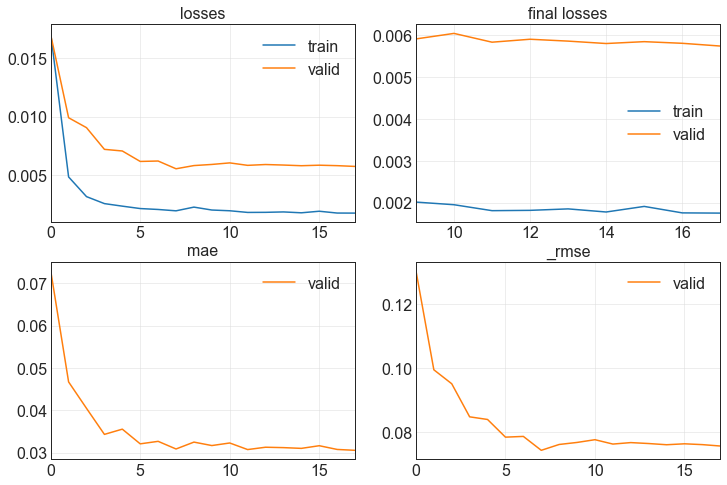

93.56299376487732                                                                                                      
[0.0017493150662630796, 0.005743714980781078, 0.0305560864508152, 0.07578729838132858]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 29%|███████████▌                            | 29/100 [1:03:04<2:54:36, 147.56s/trial, best loss: 0.004819139838218689]

No improvement since epoch 20: early stopping                                                                          
 29%|███████████▌                            | 29/100 [1:04:41<2:54:36, 147.56s/trial, best loss: 0.004819139838218689]

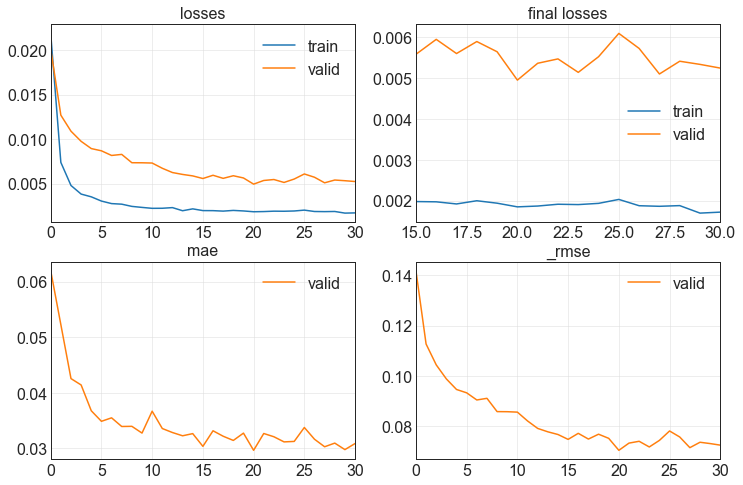

96.54586243629456                                                                                                      
[0.0017203314928337932, 0.005244078580290079, 0.030864927917718887, 0.07241601496934891]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 30%|████████████                            | 30/100 [1:04:42<2:34:47, 132.68s/trial, best loss: 0.004819139838218689]

No improvement since epoch 12: early stopping                                                                          
 30%|████████████                            | 30/100 [1:06:43<2:34:47, 132.68s/trial, best loss: 0.004819139838218689]

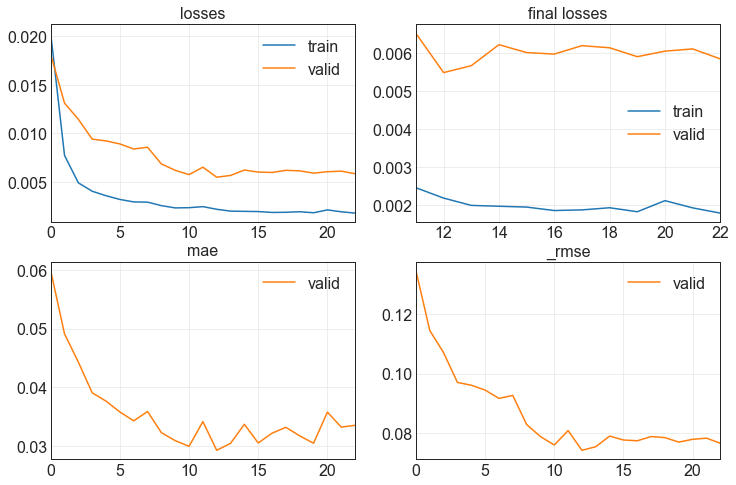

120.80840730667114                                                                                                     
[0.0017921640537679195, 0.005850271321833134, 0.03351917490363121, 0.07648707181215286]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 31%|████████████▍                           | 31/100 [1:06:45<2:28:58, 129.54s/trial, best loss: 0.004819139838218689]

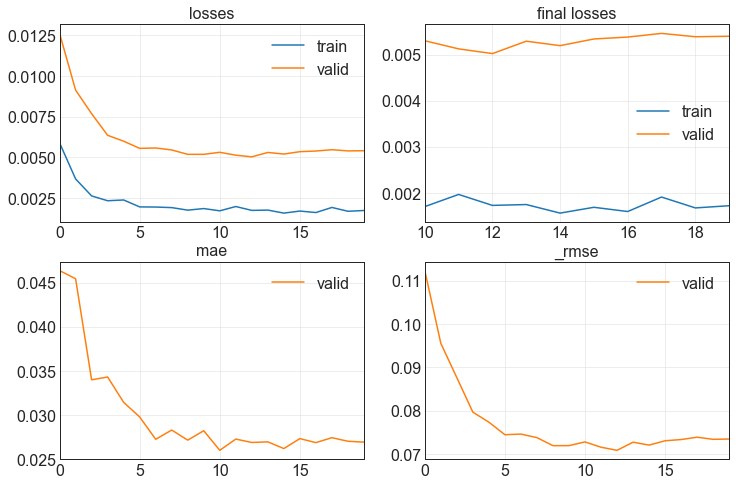

197.50162386894226                                                                                                     
[0.0017187873600050807, 0.005397094413638115, 0.026897909119725227, 0.07346491515636444]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 32%|████████████▊                           | 32/100 [1:10:04<2:50:24, 150.36s/trial, best loss: 0.004819139838218689]

No improvement since epoch 43: early stopping                                                                          
 32%|████████████▊                           | 32/100 [1:11:31<2:50:24, 150.36s/trial, best loss: 0.004819139838218689]

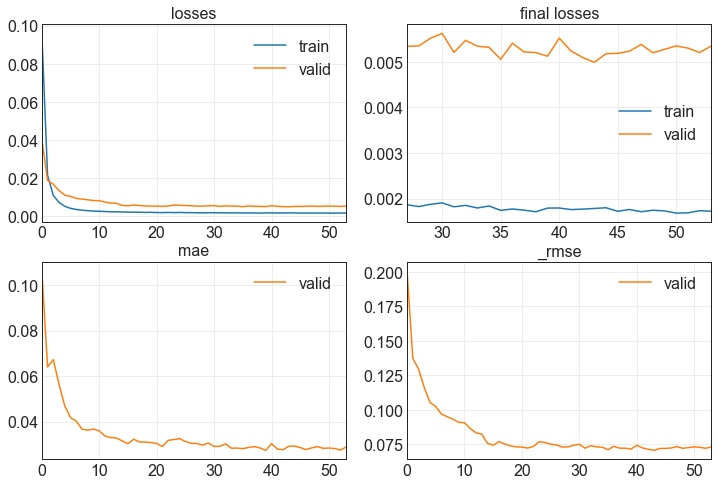

87.54257202148438                                                                                                      
[0.0017200944712385535, 0.005349664483219385, 0.02884068712592125, 0.07314139604568481]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 33%|█████████████▏                          | 33/100 [1:11:33<2:27:20, 131.95s/trial, best loss: 0.004819139838218689]

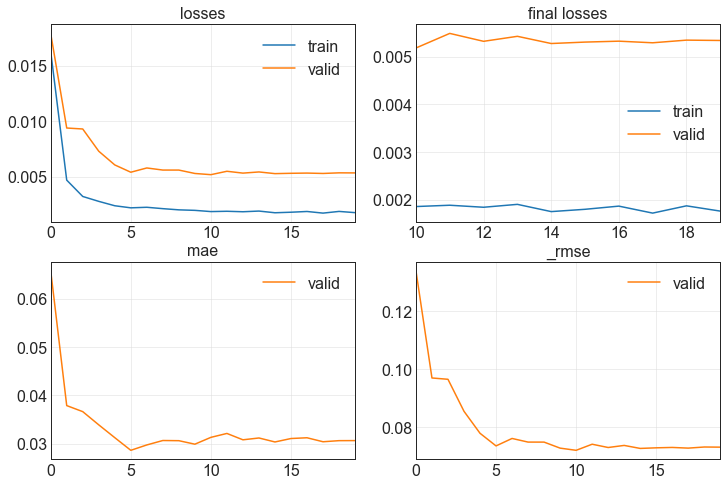

102.03307318687439                                                                                                     
[0.0017569706542417407, 0.0053372434340417385, 0.030625438317656517, 0.07305643707513809]                              
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 34%|█████████████▌                          | 34/100 [1:13:16<2:15:44, 123.41s/trial, best loss: 0.004819139838218689]

No improvement since epoch 26: early stopping                                                                          
 34%|█████████████▌                          | 34/100 [1:14:06<2:15:44, 123.41s/trial, best loss: 0.004819139838218689]

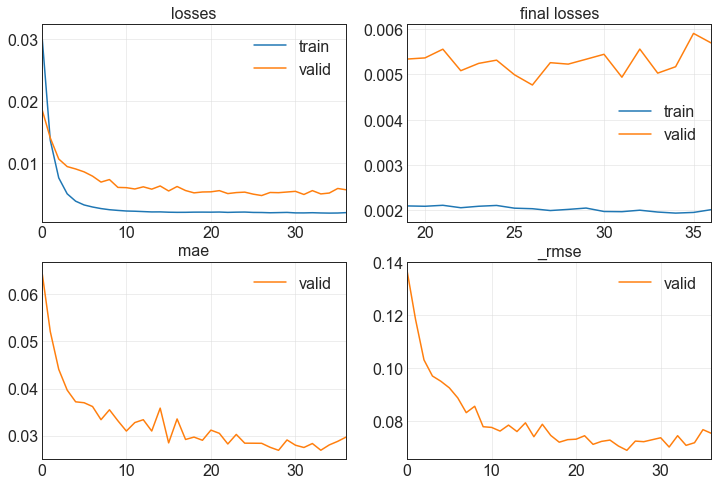

50.762380838394165                                                                                                     
[0.002016297308728099, 0.00569245545193553, 0.02971351146697998, 0.07544835656881332]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 35%|██████████████                          | 35/100 [1:14:08<1:50:33, 102.05s/trial, best loss: 0.004819139838218689]

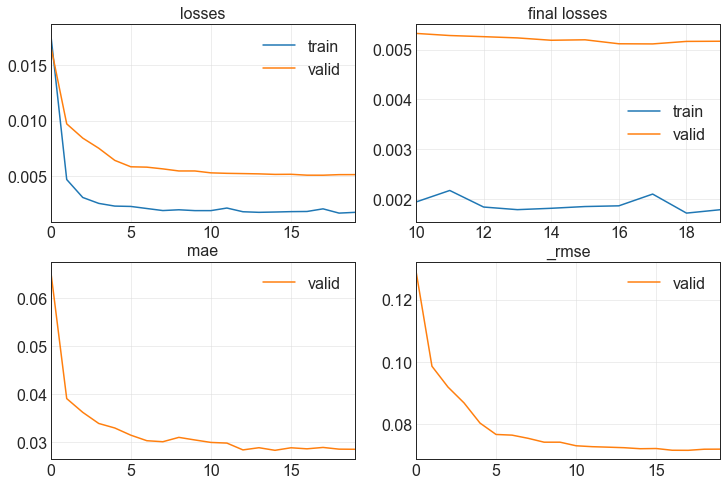

60.65335249900818                                                                                                      
[0.0017832951853051782, 0.005166234448552132, 0.028465071693062782, 0.07187651097774506]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 36%|██████████████▊                          | 36/100 [1:15:10<1:36:03, 90.06s/trial, best loss: 0.004819139838218689]

No improvement since epoch 17: early stopping                                                                          
 36%|██████████████▊                          | 36/100 [1:16:23<1:36:03, 90.06s/trial, best loss: 0.004819139838218689]

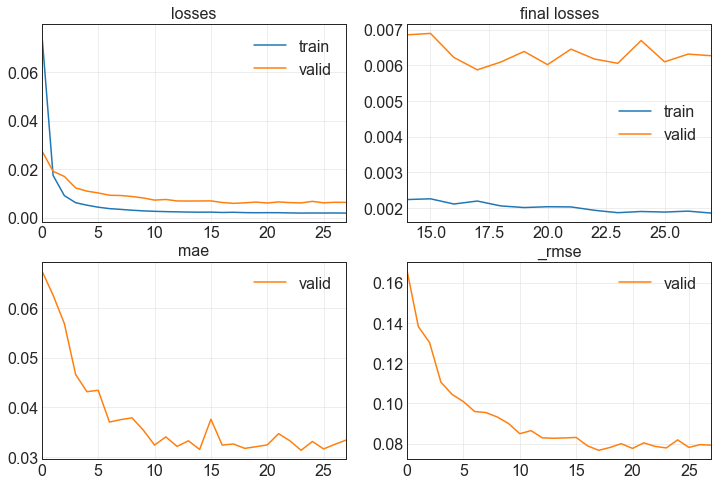

73.29123759269714                                                                                                      
[0.001852879417128861, 0.006268148310482502, 0.033382926136255264, 0.07917163521051407]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 37%|███████████████▏                         | 37/100 [1:16:25<1:29:44, 85.46s/trial, best loss: 0.004819139838218689]

No improvement since epoch 1: early stopping                                                                           
 37%|███████████████▏                         | 37/100 [1:18:25<1:29:44, 85.46s/trial, best loss: 0.004819139838218689]

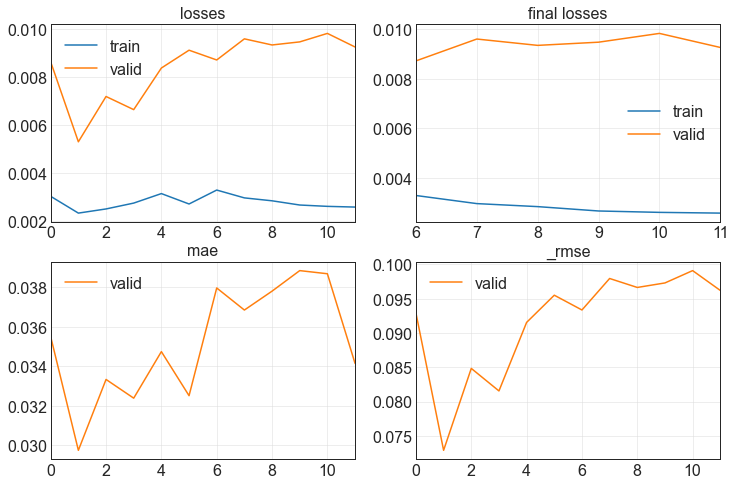

120.59220314025879                                                                                                     
[0.0025968817062675953, 0.009256716817617416, 0.034146636724472046, 0.09621183574199677]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 38%|███████████████▌                         | 38/100 [1:18:27<1:39:38, 96.43s/trial, best loss: 0.004819139838218689]

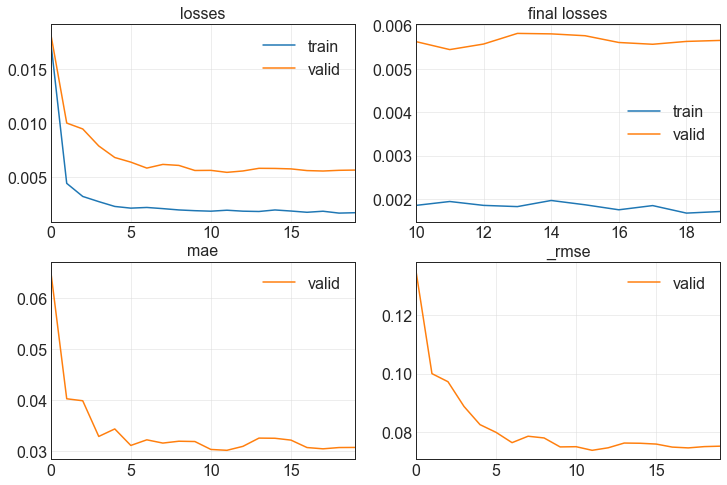

103.17421269416809                                                                                                     
[0.0017138422699645162, 0.0056539978832006454, 0.03073032759130001, 0.07519306987524033]                               
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 39%|███████████████▉                         | 39/100 [1:20:12<1:40:31, 98.88s/trial, best loss: 0.004819139838218689]

No improvement since epoch 33: early stopping                                                                          
 39%|███████████████▉                         | 39/100 [1:20:46<1:40:31, 98.88s/trial, best loss: 0.004819139838218689]

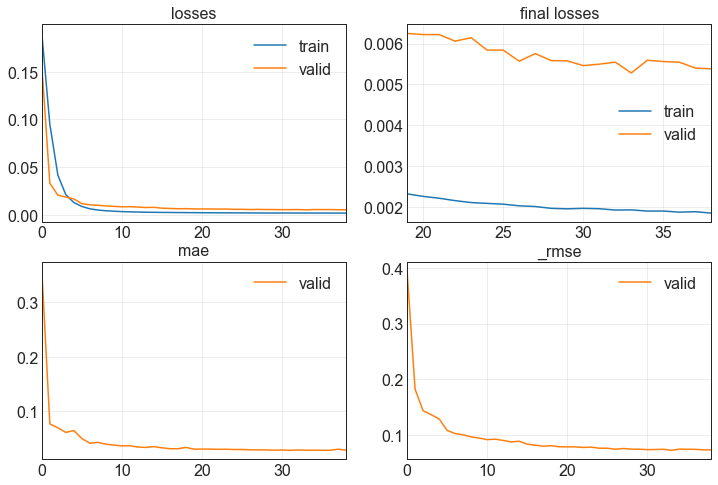

34.86412811279297                                                                                                      
[0.0018536734860390425, 0.005380767863243818, 0.028906937688589096, 0.07335371524095535]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 40%|████████████████▍                        | 40/100 [1:20:48<1:20:08, 80.15s/trial, best loss: 0.004819139838218689]

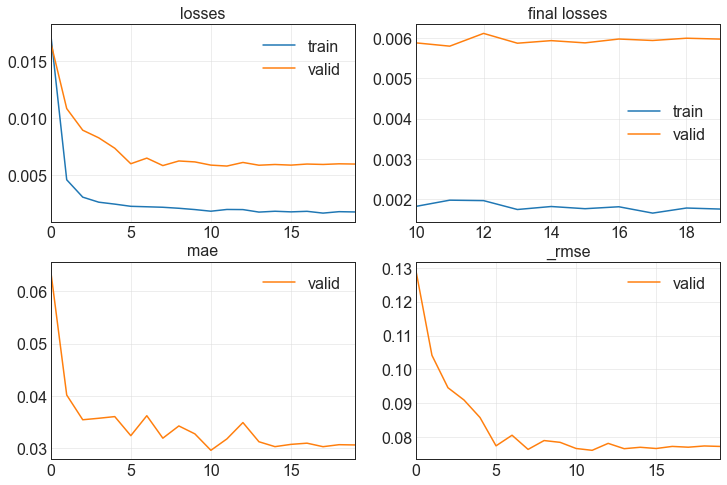

103.13461494445801                                                                                                     
[0.001758494065143168, 0.00597287667915225, 0.03062327392399311, 0.07728438824415207]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 41%|████████████████▊                        | 41/100 [1:22:33<1:26:01, 87.48s/trial, best loss: 0.004819139838218689]

No improvement since epoch 7: early stopping                                                                           
 41%|████████████████▊                        | 41/100 [1:23:20<1:26:01, 87.48s/trial, best loss: 0.004819139838218689]

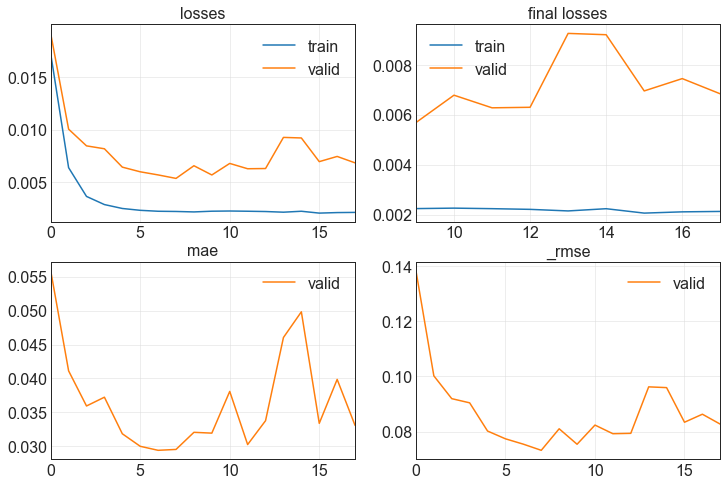

48.12099361419678                                                                                                      
[0.002126252045854926, 0.006835227832198143, 0.03306899964809418, 0.08267543464899063]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 42%|█████████████████▏                       | 42/100 [1:23:22<1:13:35, 76.12s/trial, best loss: 0.004819139838218689]

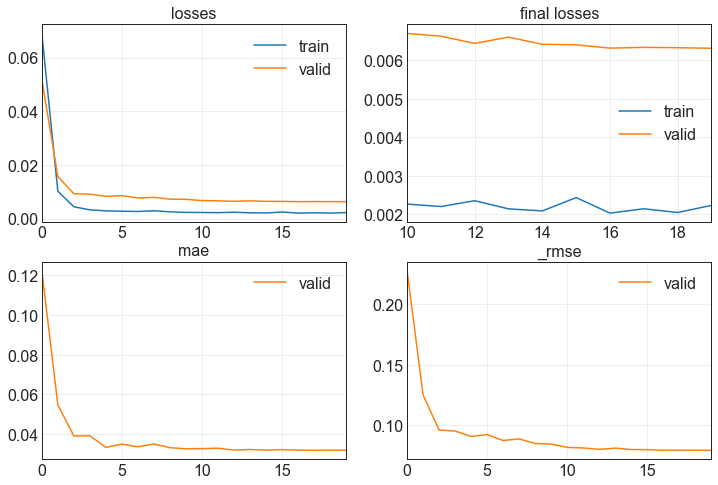

167.4829065799713                                                                                                      
[0.0022334603127092123, 0.006311650853604078, 0.03184330835938454, 0.07944590598344803]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 43%|█████████████████▏                      | 43/100 [1:26:11<1:38:46, 103.98s/trial, best loss: 0.004819139838218689]

No improvement since epoch 23: early stopping                                                                          
 43%|█████████████████▏                      | 43/100 [1:27:53<1:38:46, 103.98s/trial, best loss: 0.004819139838218689]

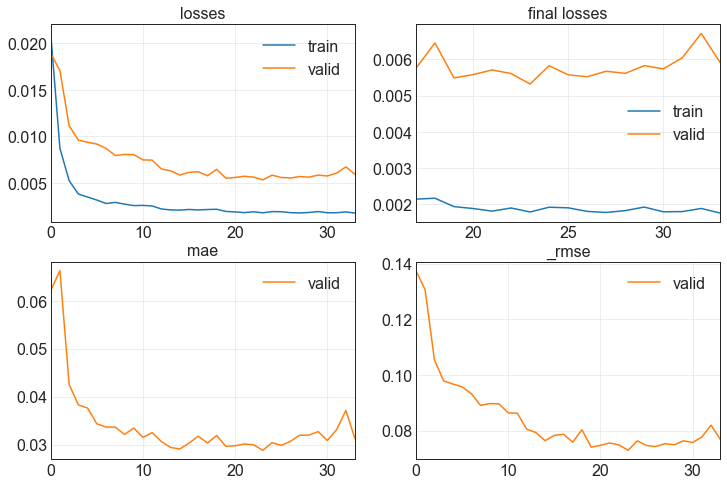

102.14364123344421                                                                                                     
[0.0017499750247225165, 0.005907151848077774, 0.0311866644769907, 0.07685800641775131]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 44%|█████████████████▌                      | 44/100 [1:27:55<1:36:56, 103.86s/trial, best loss: 0.004819139838218689]

No improvement since epoch 14: early stopping                                                                          
 44%|█████████████████▌                      | 44/100 [1:30:03<1:36:56, 103.86s/trial, best loss: 0.004819139838218689]

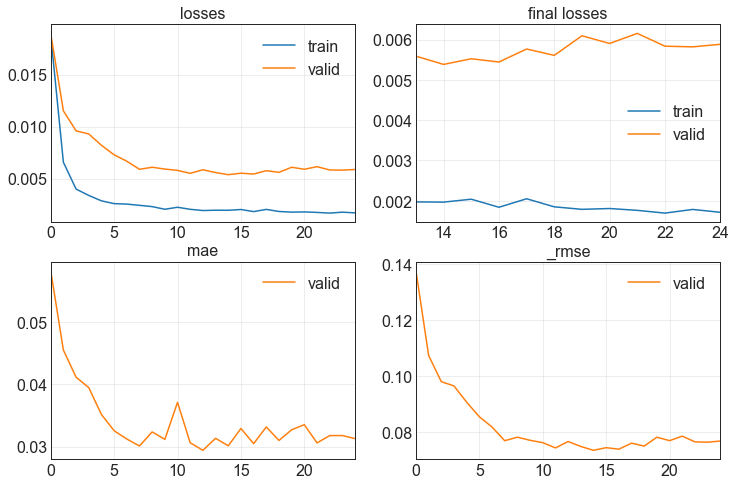

128.96160244941711                                                                                                     
[0.0017135667148977518, 0.005883380770683289, 0.03127697482705116, 0.07670319825410843]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 45%|██████████████████                      | 45/100 [1:30:05<1:42:30, 111.83s/trial, best loss: 0.004819139838218689]

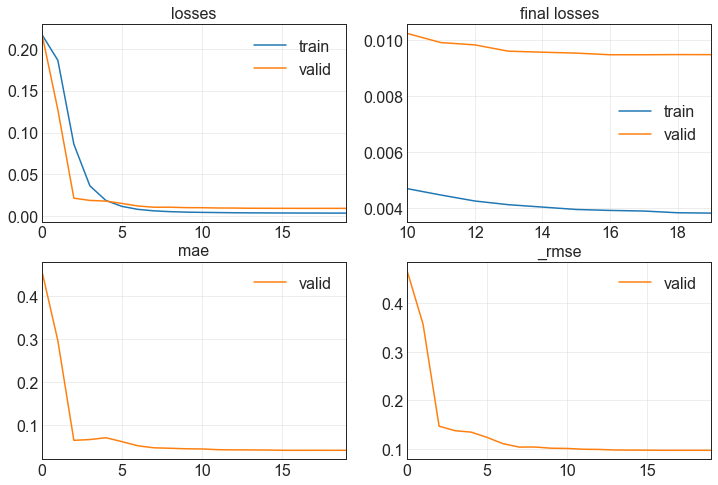

22.82784104347229                                                                                                      
[0.0038108061999082565, 0.009484775364398956, 0.041791945695877075, 0.09738980233669281]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 46%|██████████████████▊                      | 46/100 [1:30:30<1:17:00, 85.57s/trial, best loss: 0.004819139838218689]

No improvement since epoch 9: early stopping                                                                           
 46%|██████████████████▊                      | 46/100 [1:31:24<1:17:00, 85.57s/trial, best loss: 0.004819139838218689]

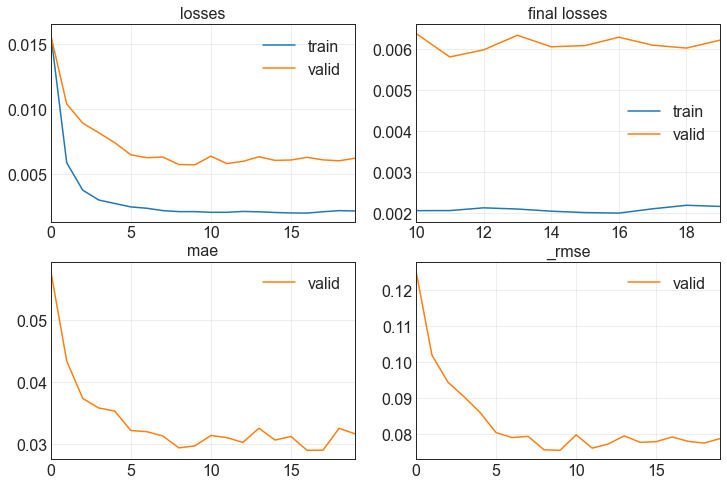

54.43913912773132                                                                                                      
[0.002165052108466625, 0.006216564681380987, 0.03162374347448349, 0.07884520292282104]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 47%|███████████████████▎                     | 47/100 [1:31:25<1:07:42, 76.66s/trial, best loss: 0.004819139838218689]

No improvement since epoch 16: early stopping                                                                          
 47%|███████████████████▎                     | 47/100 [1:32:56<1:07:42, 76.66s/trial, best loss: 0.004819139838218689]

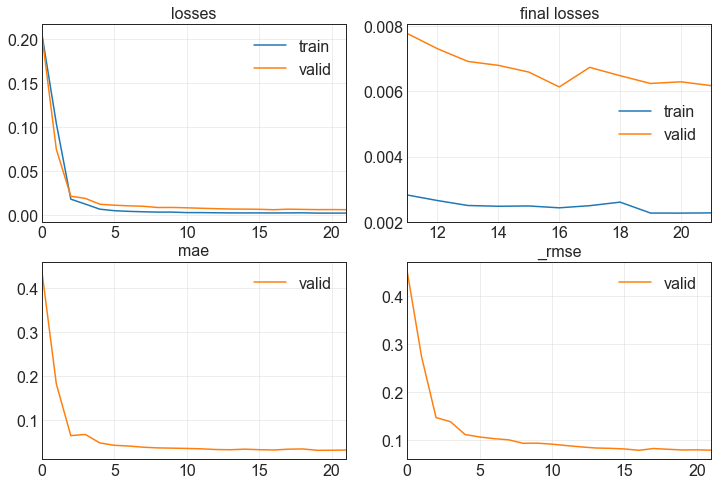

91.02823758125305                                                                                                      
[0.0022750627249479294, 0.006171305198222399, 0.030942432582378387, 0.07855764776468277]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 48%|███████████████████▋                     | 48/100 [1:32:58<1:10:32, 81.40s/trial, best loss: 0.004819139838218689]

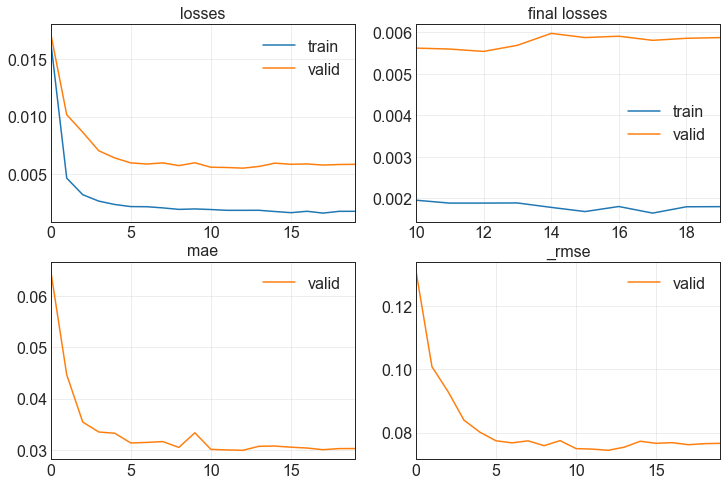

103.13637113571167                                                                                                     
[0.0018021661089733243, 0.0058719865046441555, 0.030274827033281326, 0.07662888616323471]                              
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 49%|████████████████████                     | 49/100 [1:34:43<1:15:07, 88.38s/trial, best loss: 0.004819139838218689]

No improvement since epoch 14: early stopping                                                                          
 49%|████████████████████                     | 49/100 [1:35:04<1:15:07, 88.38s/trial, best loss: 0.004819139838218689]

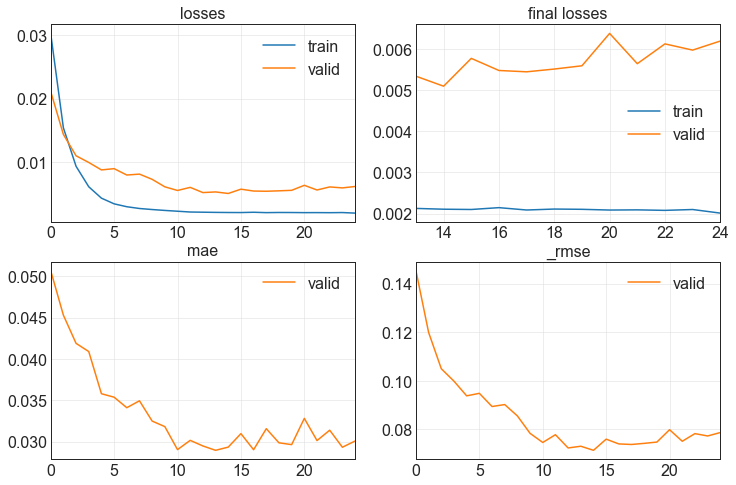

21.355419635772705                                                                                                     
[0.002012508688494563, 0.006191774271428585, 0.030076153576374054, 0.07868782430887222]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 50%|█████████████████████▌                     | 50/100 [1:35:05<57:16, 68.72s/trial, best loss: 0.004819139838218689]

No improvement since epoch 17: early stopping                                                                          
 50%|█████████████████████▌                     | 50/100 [1:39:03<57:16, 68.72s/trial, best loss: 0.004819139838218689]

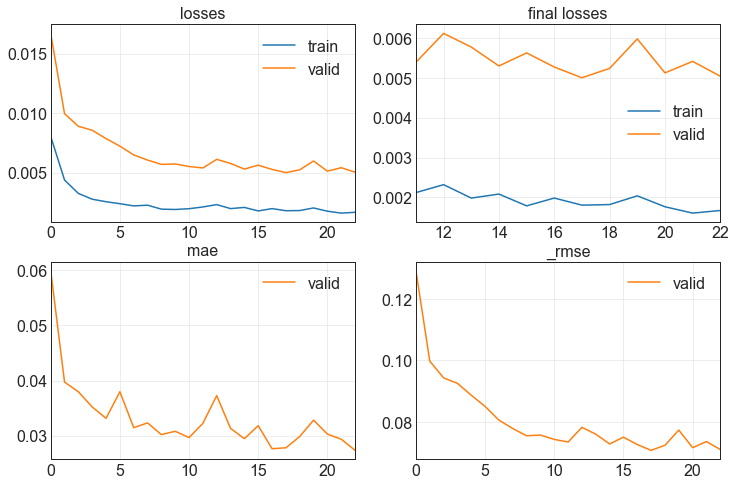

237.71057963371277                                                                                                     
[0.0016686306335031986, 0.005042207892984152, 0.027350006625056267, 0.07100848853588104]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 51%|████████████████████▍                   | 51/100 [1:39:05<1:37:52, 119.85s/trial, best loss: 0.004819139838218689]

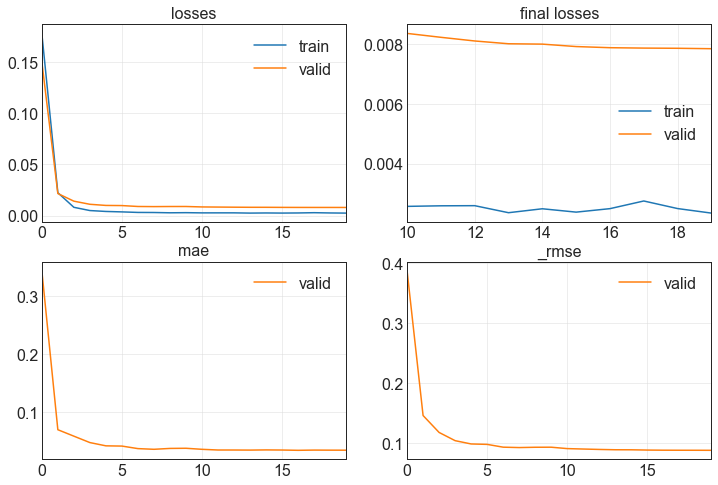

84.32528495788574                                                                                                      
[0.002337557729333639, 0.007852748967707157, 0.034710612148046494, 0.08861574530601501]                                
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 52%|████████████████████▊                   | 52/100 [1:40:30<1:27:42, 109.64s/trial, best loss: 0.004819139838218689]

No improvement since epoch 24: early stopping                                                                          
 52%|████████████████████▊                   | 52/100 [1:42:04<1:27:42, 109.64s/trial, best loss: 0.004819139838218689]

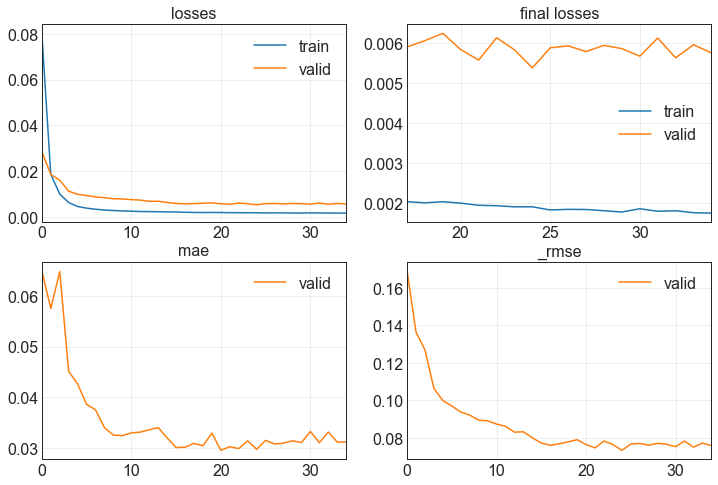

94.19713640213013                                                                                                      
[0.0017541773850098252, 0.005761812441051006, 0.031180787831544876, 0.07590659707784653]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 53%|█████████████████████▏                  | 53/100 [1:42:06<1:22:36, 105.45s/trial, best loss: 0.004819139838218689]

No improvement since epoch 7: early stopping                                                                           
 53%|█████████████████████▏                  | 53/100 [1:43:13<1:22:36, 105.45s/trial, best loss: 0.004819139838218689]

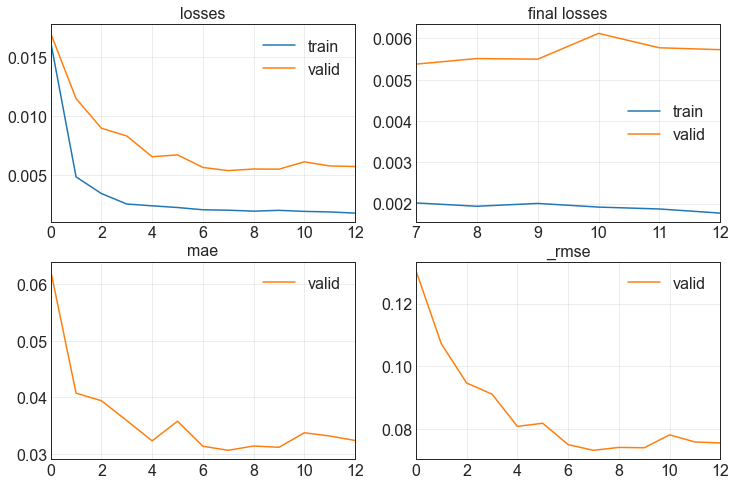

66.992511510849                                                                                                        
[0.0017689800588414073, 0.005728797055780888, 0.03238924220204353, 0.07568881660699844]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 54%|██████████████████████▏                  | 54/100 [1:43:15<1:12:20, 94.36s/trial, best loss: 0.004819139838218689]

No improvement since epoch 7: early stopping                                                                           
 54%|██████████████████████▏                  | 54/100 [1:44:45<1:12:20, 94.36s/trial, best loss: 0.004819139838218689]

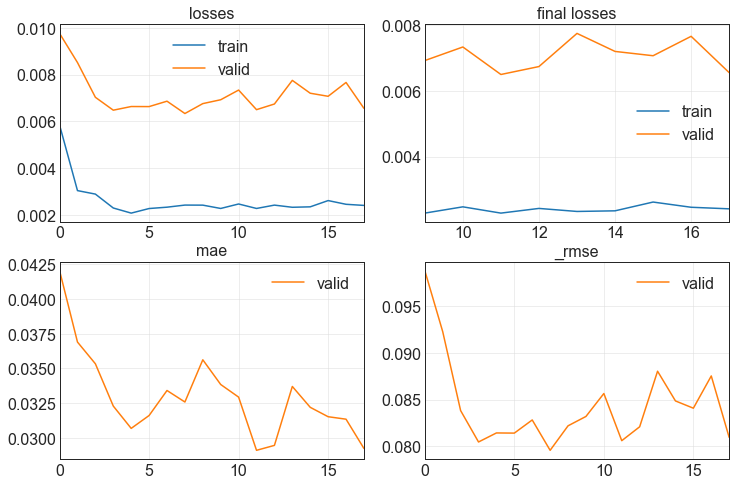

90.68500590324402                                                                                                      
[0.002405668841674924, 0.00655495747923851, 0.0292425025254488, 0.08096269518136978]                                   
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 55%|██████████████████████▌                  | 55/100 [1:44:47<1:10:15, 93.68s/trial, best loss: 0.004819139838218689]

No improvement since epoch 69: early stopping                                                                          
 55%|██████████████████████▌                  | 55/100 [1:46:12<1:10:15, 93.68s/trial, best loss: 0.004819139838218689]

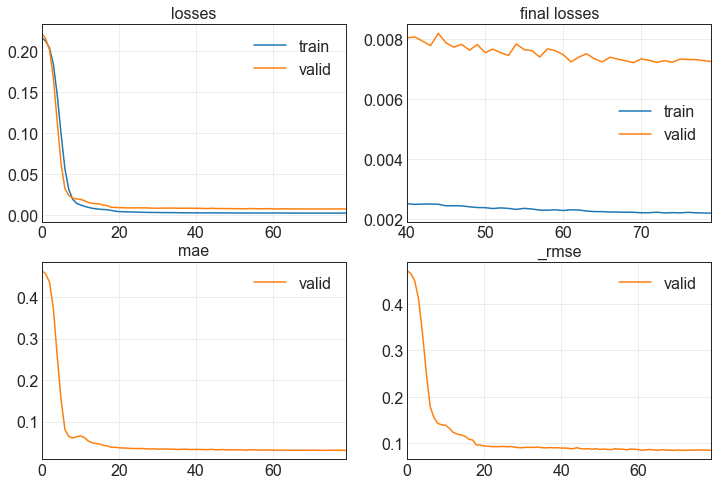

85.71583104133606                                                                                                      
[0.002211797283962369, 0.007254123222082853, 0.030711926519870758, 0.08517114073038101]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 56%|██████████████████████▉                  | 56/100 [1:46:14<1:07:15, 91.72s/trial, best loss: 0.004819139838218689]

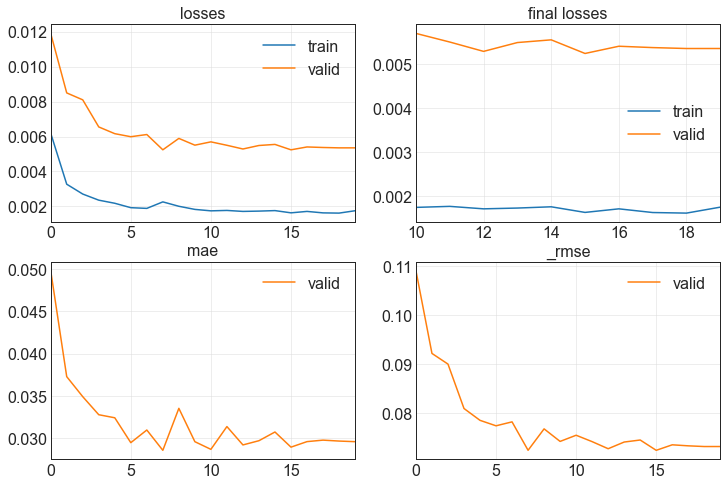

121.21563839912415                                                                                                     
[0.0017511378973722458, 0.005351171363145113, 0.029580632224678993, 0.07315170019865036]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 57%|██████████████████████▊                 | 57/100 [1:48:16<1:12:22, 101.00s/trial, best loss: 0.004819139838218689]

No improvement since epoch 19: early stopping                                                                          
 57%|██████████████████████▊                 | 57/100 [1:50:27<1:12:22, 101.00s/trial, best loss: 0.004819139838218689]

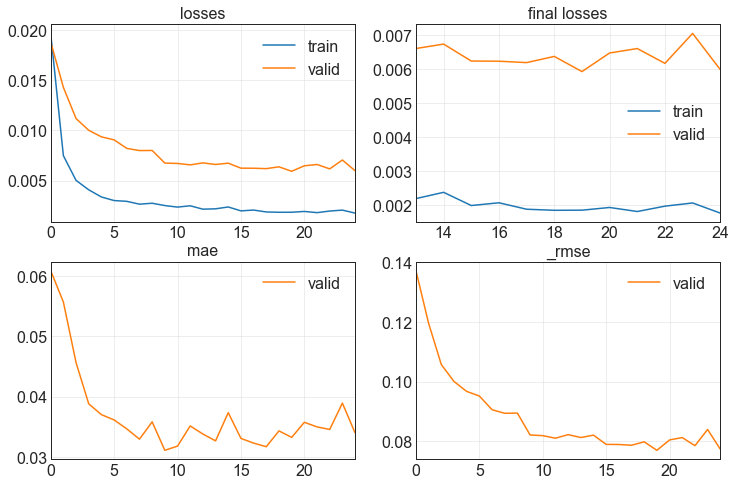

131.1078531742096                                                                                                      
[0.0017590050119906664, 0.005979777313768864, 0.03401961922645569, 0.07732901722192764]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 58%|███████████████████████▏                | 58/100 [1:50:29<1:17:19, 110.46s/trial, best loss: 0.004819139838218689]

No improvement since epoch 18: early stopping                                                                          
 58%|███████████████████████▏                | 58/100 [1:52:59<1:17:19, 110.46s/trial, best loss: 0.004819139838218689]

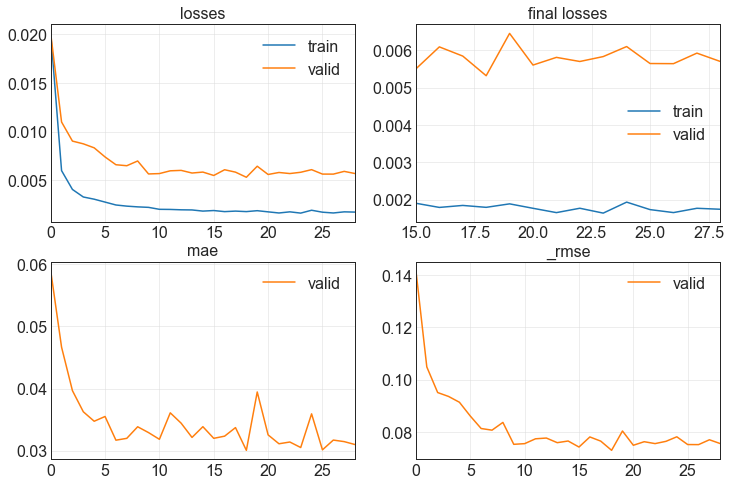

150.49368596076965                                                                                                     
[0.0017437874339520931, 0.0056992569006979465, 0.030986130237579346, 0.07549342513084412]                              
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 59%|███████████████████████▌                | 59/100 [1:53:01<1:23:59, 122.91s/trial, best loss: 0.004819139838218689]

No improvement since epoch 11: early stopping                                                                          
 59%|███████████████████████▌                | 59/100 [1:53:58<1:23:59, 122.91s/trial, best loss: 0.004819139838218689]

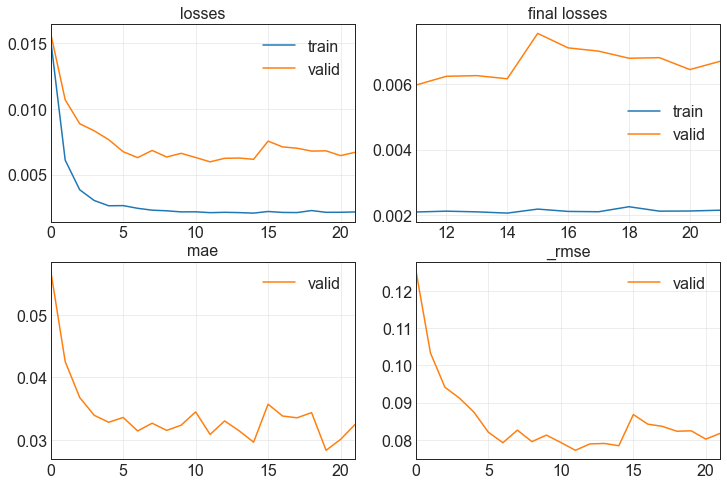

57.11540627479553                                                                                                      
[0.0021541365422308445, 0.006690335925668478, 0.03247655928134918, 0.08179448544979095]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 60%|████████████████████████                | 60/100 [1:53:59<1:09:04, 103.61s/trial, best loss: 0.004819139838218689]

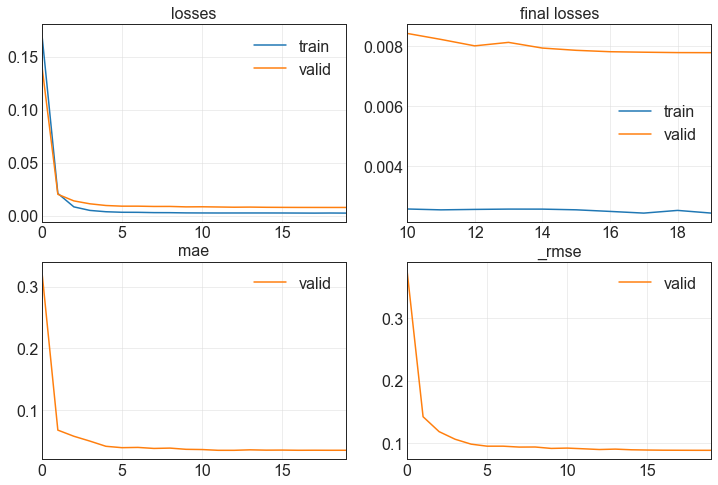

86.3626856803894                                                                                                       
[0.0024463962763547897, 0.00777528015896678, 0.0349234864115715, 0.08817755430936813]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 61%|█████████████████████████                | 61/100 [1:55:27<1:04:15, 98.86s/trial, best loss: 0.004819139838218689]

No improvement since epoch 19: early stopping                                                                          
 61%|█████████████████████████                | 61/100 [1:55:50<1:04:15, 98.86s/trial, best loss: 0.004819139838218689]

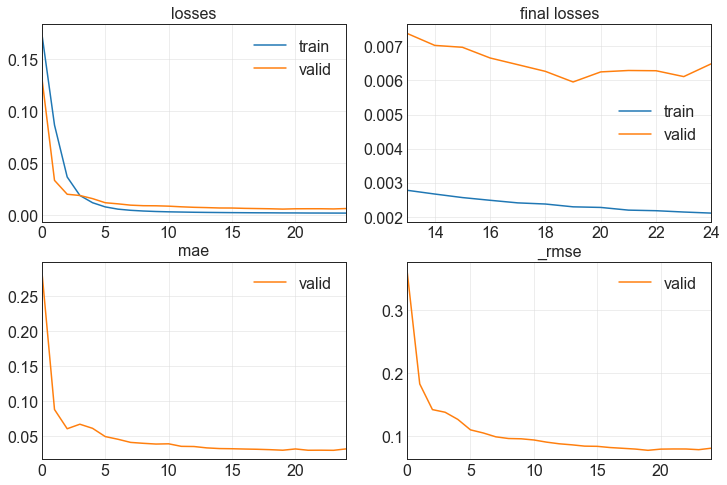

23.507965326309204                                                                                                     
[0.0021082053426653147, 0.006489933002740145, 0.03147363290190697, 0.0805601179599762]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 62%|██████████████████████████▋                | 62/100 [1:55:52<48:35, 76.71s/trial, best loss: 0.004819139838218689]

No improvement since epoch 7: early stopping                                                                           
 62%|██████████████████████████▋                | 62/100 [1:58:58<48:35, 76.71s/trial, best loss: 0.004819139838218689]

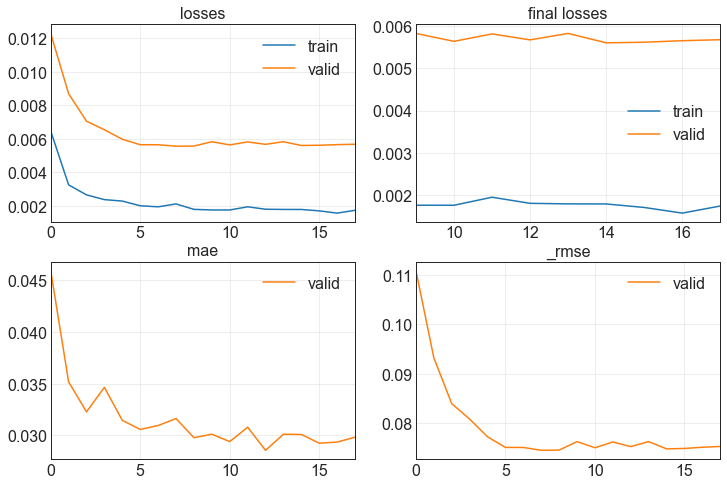

185.82725620269775                                                                                                     
[0.0017409154679626226, 0.005679277237504721, 0.029838500544428825, 0.0753609761595726]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 63%|█████████████████████████▏              | 63/100 [1:59:00<1:07:47, 109.92s/trial, best loss: 0.004819139838218689]

No improvement since epoch 42: early stopping                                                                          
 63%|█████████████████████████▏              | 63/100 [2:03:37<1:07:47, 109.92s/trial, best loss: 0.004819139838218689]

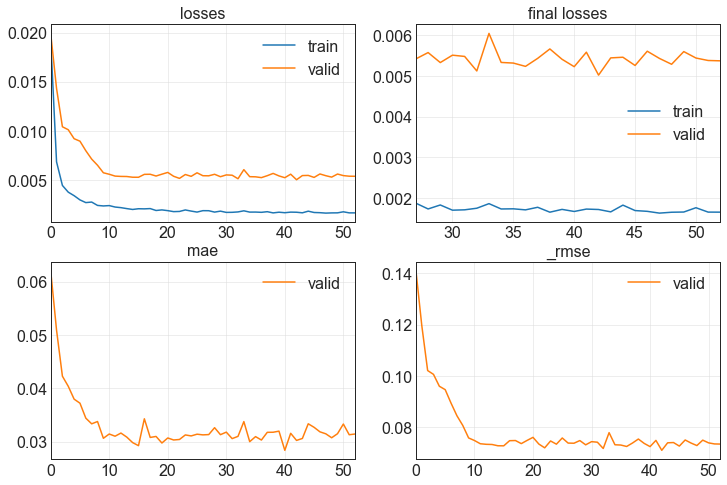

277.922402381897                                                                                                       
[0.001646157237701118, 0.005370229948312044, 0.03144056722521782, 0.07328184694051743]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.1, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 64%|█████████████████████████▌              | 64/100 [2:03:40<1:36:28, 160.80s/trial, best loss: 0.004819139838218689]

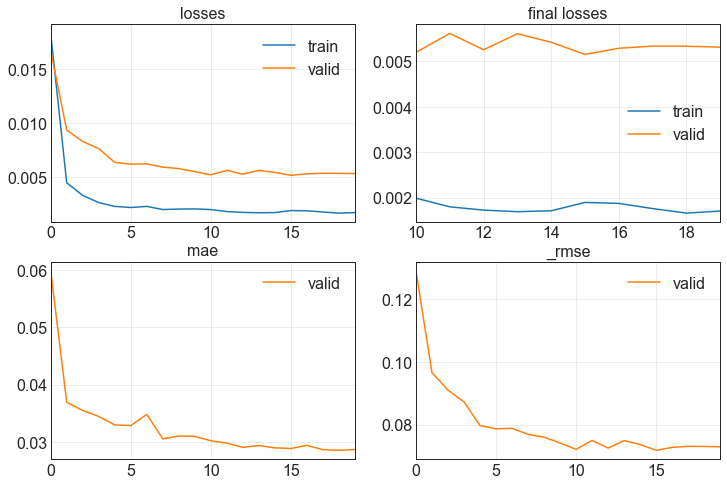

106.77208590507507                                                                                                     
[0.0017031833995133638, 0.00531447259709239, 0.028677163645625114, 0.0729004293680191]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 65%|██████████████████████████              | 65/100 [2:05:28<1:24:38, 145.10s/trial, best loss: 0.004819139838218689]

No improvement since epoch 13: early stopping                                                                          
 65%|██████████████████████████              | 65/100 [2:08:47<1:24:38, 145.10s/trial, best loss: 0.004819139838218689]

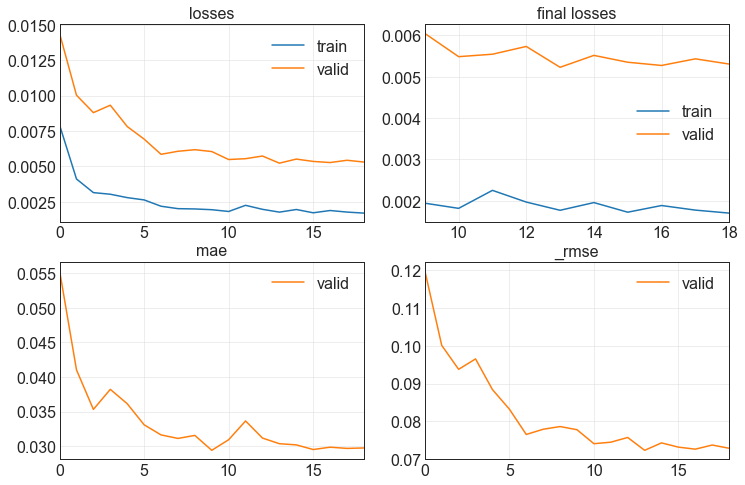

199.55641388893127                                                                                                     
[0.0017006760463118553, 0.005306284409016371, 0.029737258329987526, 0.0728442445397377]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 66%|██████████████████████████▍             | 66/100 [2:08:49<1:31:43, 161.87s/trial, best loss: 0.004819139838218689]

No improvement since epoch 11: early stopping                                                                          
 66%|██████████████████████████▍             | 66/100 [2:11:42<1:31:43, 161.87s/trial, best loss: 0.004819139838218689]

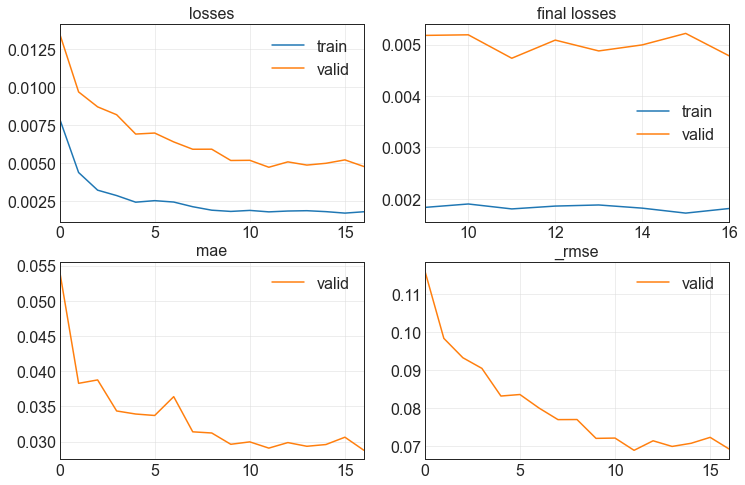

173.7568175792694                                                                                                      
[0.001811830559745431, 0.004781624767929316, 0.02874857373535633, 0.06914929300546646]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 67%|██████████████████████████▊             | 67/100 [2:11:44<1:31:13, 165.88s/trial, best loss: 0.004781624767929316]

No improvement since epoch 16: early stopping                                                                          
 67%|██████████████████████████▊             | 67/100 [2:15:31<1:31:13, 165.88s/trial, best loss: 0.004781624767929316]

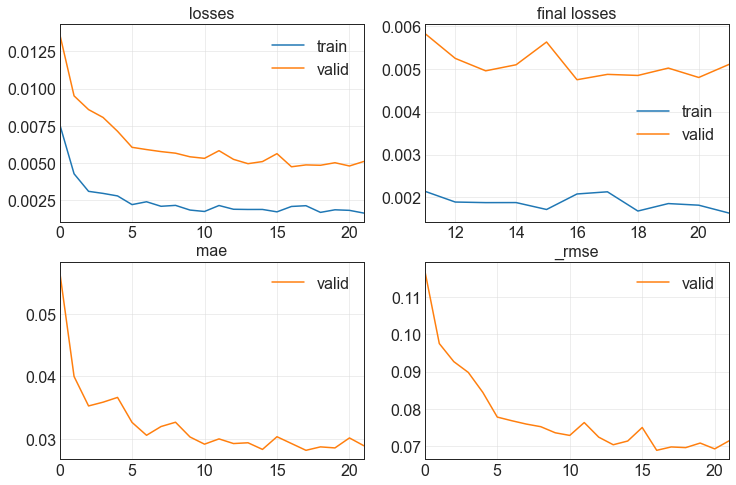

227.29582238197327                                                                                                     
[0.0016343242023140192, 0.005105101503431797, 0.02894325740635395, 0.07145000249147415]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 68%|███████████████████████████▏            | 68/100 [2:15:33<1:38:32, 184.77s/trial, best loss: 0.004781624767929316]

No improvement since epoch 12: early stopping                                                                          
 68%|███████████████████████████▏            | 68/100 [2:18:42<1:38:32, 184.77s/trial, best loss: 0.004781624767929316]

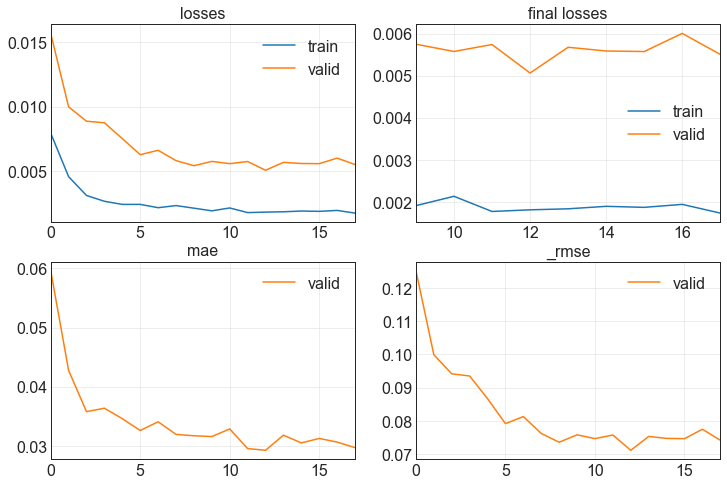

189.66565418243408                                                                                                     
[0.0017314006108790636, 0.005502834916114807, 0.02969428338110447, 0.07418110221624374]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 69%|███████████████████████████▌            | 69/100 [2:18:44<1:36:27, 186.69s/trial, best loss: 0.004781624767929316]

No improvement since epoch 13: early stopping                                                                          
 69%|███████████████████████████▌            | 69/100 [2:22:04<1:36:27, 186.69s/trial, best loss: 0.004781624767929316]

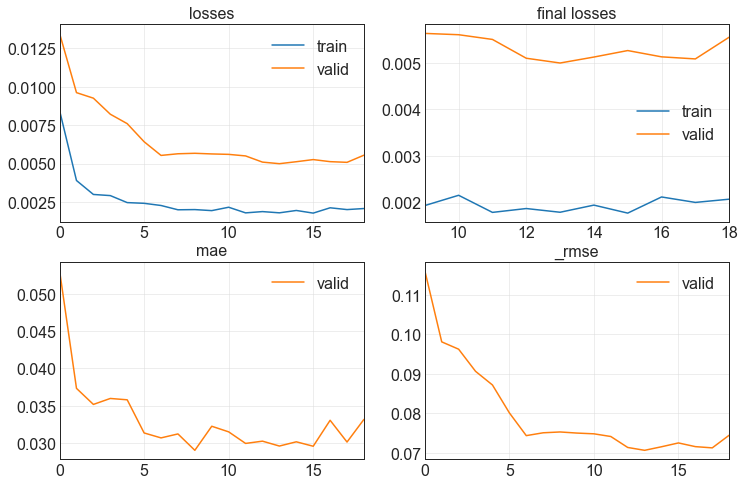

200.46769976615906                                                                                                     
[0.002075339201837778, 0.0055497270077466965, 0.03317145258188248, 0.07449649274349213]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 70%|████████████████████████████            | 70/100 [2:22:06<1:35:37, 191.26s/trial, best loss: 0.004781624767929316]

No improvement since epoch 23: early stopping                                                                          
 70%|████████████████████████████            | 70/100 [2:27:06<1:35:37, 191.26s/trial, best loss: 0.004781624767929316]

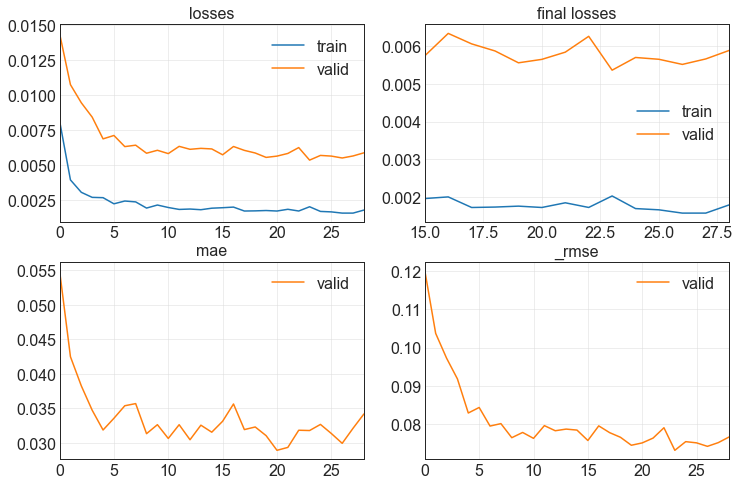

300.5071301460266                                                                                                      
[0.0017984879668802023, 0.005886287894099951, 0.034203797578811646, 0.076722152531147]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 71%|████████████████████████████▍           | 71/100 [2:27:08<1:48:30, 224.48s/trial, best loss: 0.004781624767929316]

No improvement since epoch 22: early stopping                                                                          
 71%|████████████████████████████▍           | 71/100 [2:31:50<1:48:30, 224.48s/trial, best loss: 0.004781624767929316]

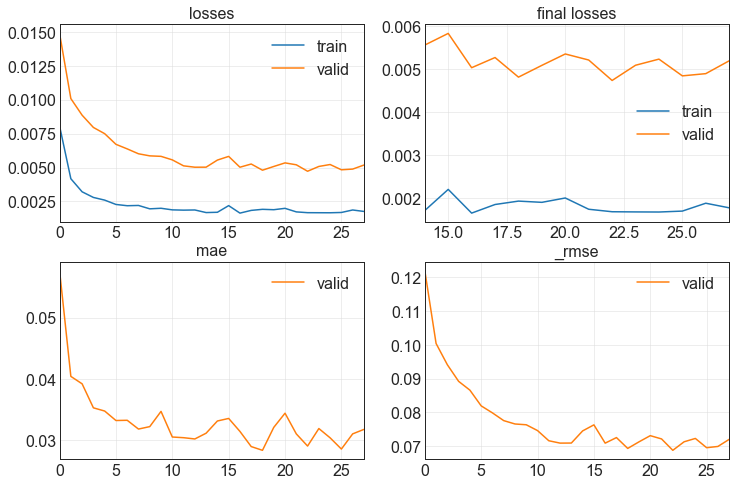

282.26434564590454                                                                                                     
[0.0017674852861091495, 0.005185264628380537, 0.03173394128680229, 0.07200879603624344]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 72%|████████████████████████████▊           | 72/100 [2:31:52<1:53:03, 242.26s/trial, best loss: 0.004781624767929316]

No improvement since epoch 10: early stopping                                                                          
 72%|████████████████████████████▊           | 72/100 [2:34:32<1:53:03, 242.26s/trial, best loss: 0.004781624767929316]

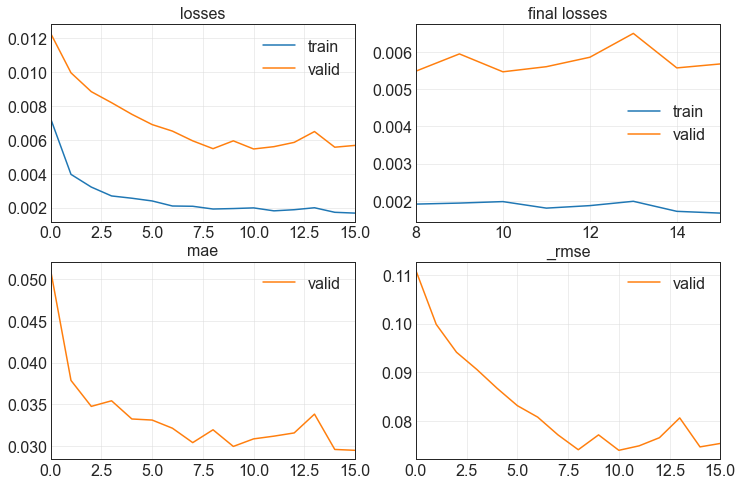

160.91254043579102                                                                                                     
[0.0016731640789657831, 0.005677134729921818, 0.029451696202158928, 0.07534676045179367]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 73%|█████████████████████████████▏          | 73/100 [2:34:34<1:38:13, 218.29s/trial, best loss: 0.004781624767929316]

No improvement since epoch 14: early stopping                                                                          
 73%|█████████████████████████████▏          | 73/100 [2:35:26<1:38:13, 218.29s/trial, best loss: 0.004781624767929316]

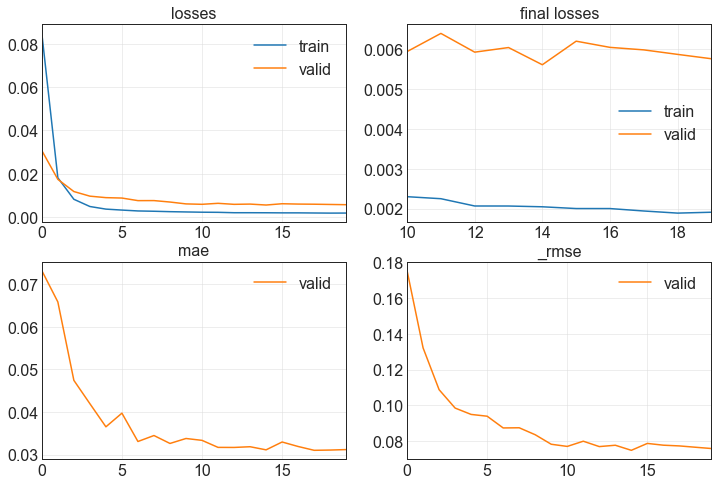

52.83121299743652                                                                                                      
[0.001909448765218258, 0.005766101647168398, 0.031159380450844765, 0.07593483477830887]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 74%|█████████████████████████████▌          | 74/100 [2:35:28<1:13:16, 169.09s/trial, best loss: 0.004781624767929316]

No improvement since epoch 14: early stopping                                                                          
 74%|█████████████████████████████▌          | 74/100 [2:37:11<1:13:16, 169.09s/trial, best loss: 0.004781624767929316]

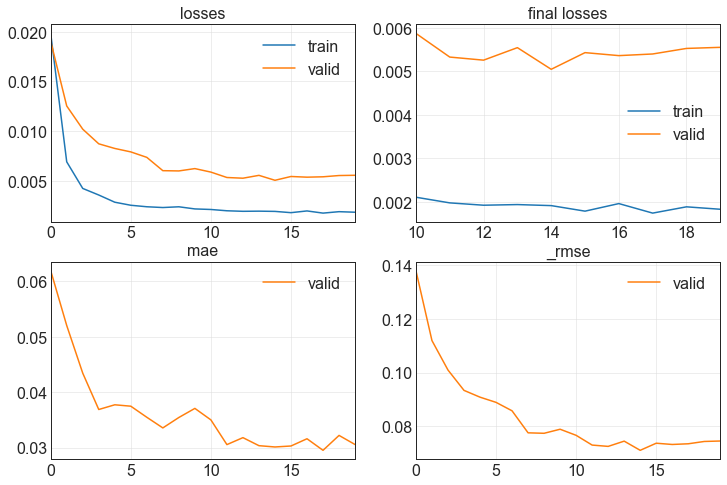

102.73345518112183                                                                                                     
[0.0018285246333107352, 0.005550816655158997, 0.030565014109015465, 0.07450380176305771]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 75%|██████████████████████████████          | 75/100 [2:37:13<1:02:20, 149.62s/trial, best loss: 0.004781624767929316]

No improvement since epoch 3: early stopping                                                                           
 75%|██████████████████████████████          | 75/100 [2:38:08<1:02:20, 149.62s/trial, best loss: 0.004781624767929316]

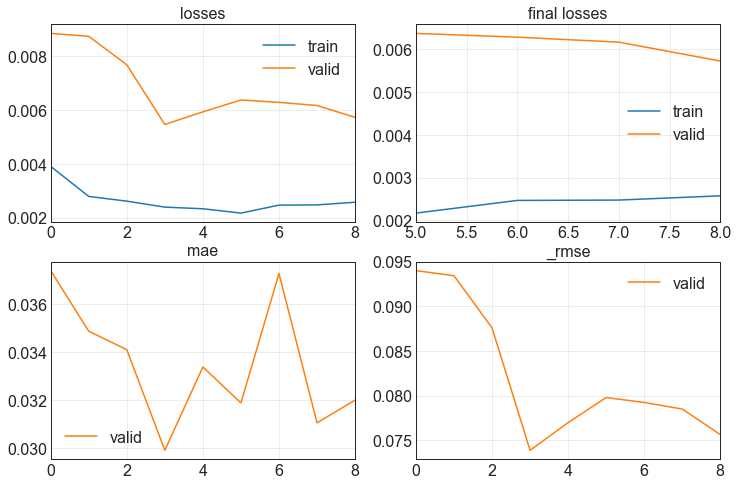

55.51722478866577                                                                                                      
[0.002573885954916477, 0.005721138324588537, 0.032001253217458725, 0.07563819736242294]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 76%|███████████████████████████████▉          | 76/100 [2:38:09<48:43, 121.83s/trial, best loss: 0.004781624767929316]

No improvement since epoch 7: early stopping                                                                           
 76%|███████████████████████████████▉          | 76/100 [2:39:45<48:43, 121.83s/trial, best loss: 0.004781624767929316]

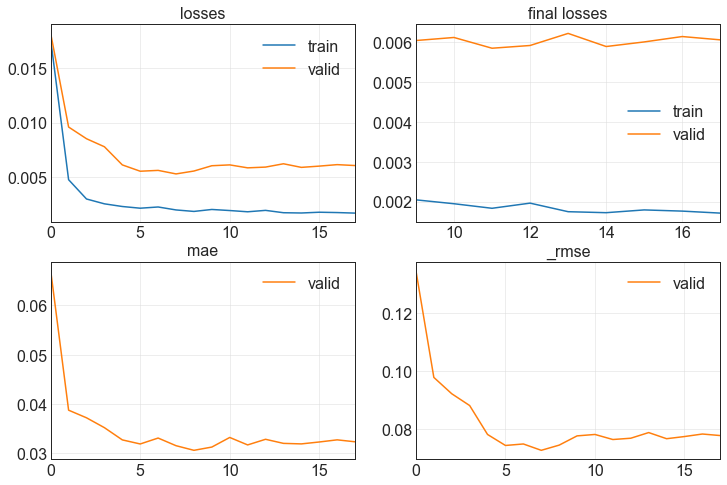

96.21509790420532                                                                                                      
[0.0017098167445510626, 0.006065947003662586, 0.03231796622276306, 0.07788418978452682]                                
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 77%|████████████████████████████████▎         | 77/100 [2:39:47<43:55, 114.58s/trial, best loss: 0.004781624767929316]

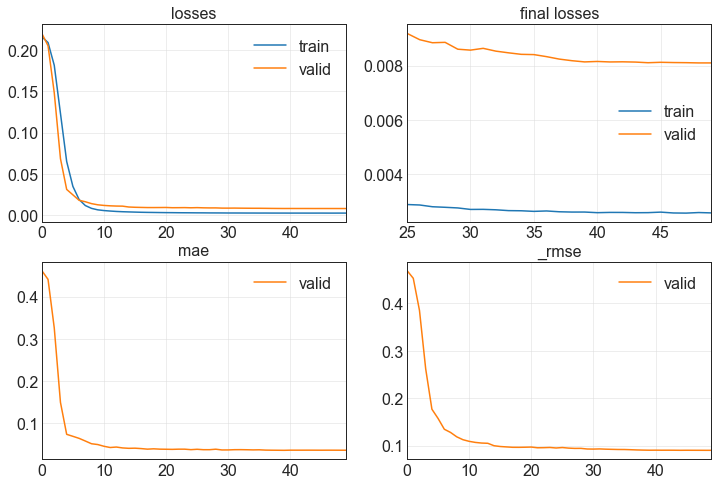

59.34086799621582                                                                                                      
[0.0025603624526411295, 0.008097605779767036, 0.03471573814749718, 0.08998669683933258]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 78%|█████████████████████████████████▌         | 78/100 [2:40:48<36:07, 98.50s/trial, best loss: 0.004781624767929316]

No improvement since epoch 39: early stopping                                                                          
 78%|█████████████████████████████████▌         | 78/100 [2:45:08<36:07, 98.50s/trial, best loss: 0.004781624767929316]

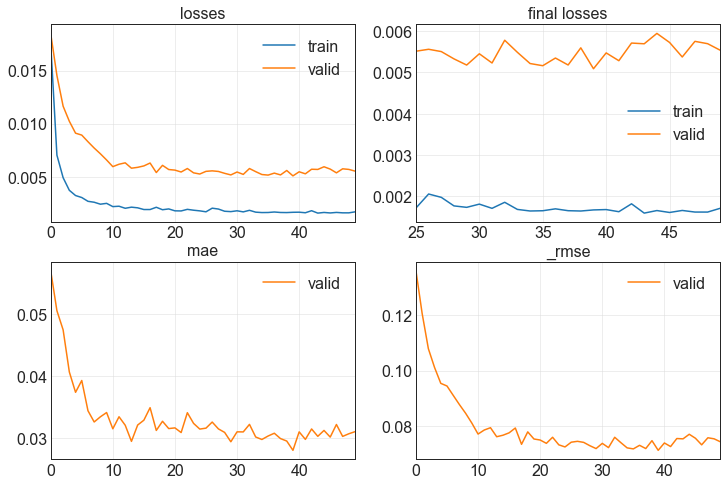

260.3069670200348                                                                                                      
[0.0017069765599444509, 0.005538691766560078, 0.031040465459227562, 0.07442238926887512]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.5, 'epochs': 20, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 79%|█████████████████████████████████▏        | 79/100 [2:45:10<51:37, 147.50s/trial, best loss: 0.004781624767929316]

No improvement since epoch 8: early stopping                                                                           
 79%|█████████████████████████████████▏        | 79/100 [2:48:28<51:37, 147.50s/trial, best loss: 0.004781624767929316]

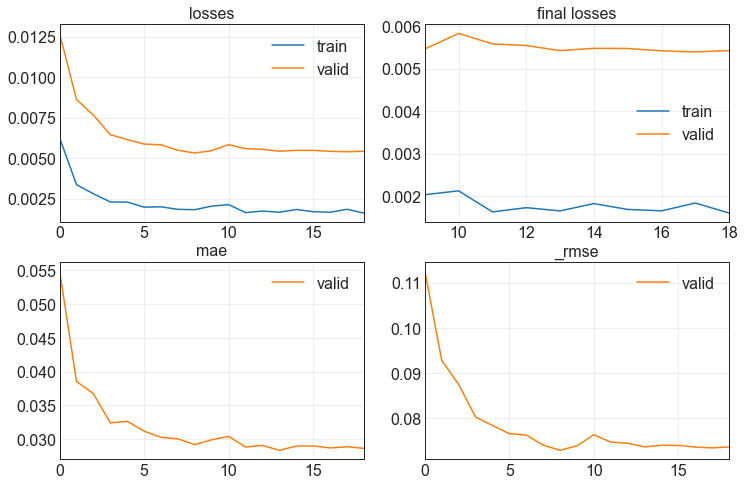

198.56874632835388                                                                                                     
[0.0016037662280723453, 0.005422502290457487, 0.028640568256378174, 0.07363763451576233]                               
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 80%|█████████████████████████████████▌        | 80/100 [2:48:30<54:24, 163.25s/trial, best loss: 0.004781624767929316]

No improvement since epoch 6: early stopping                                                                           
 80%|█████████████████████████████████▌        | 80/100 [2:48:51<54:24, 163.25s/trial, best loss: 0.004781624767929316]

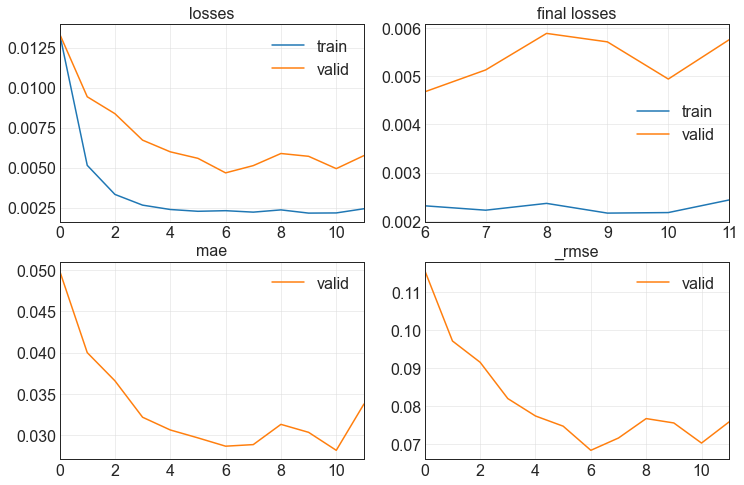

21.1295108795166                                                                                                       
[0.002432009670883417, 0.0057534328661859035, 0.03377901762723923, 0.07585138082504272]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 81%|██████████████████████████████████        | 81/100 [2:48:53<38:20, 121.08s/trial, best loss: 0.004781624767929316]

No improvement since epoch 25: early stopping                                                                          
 81%|██████████████████████████████████        | 81/100 [2:52:01<38:20, 121.08s/trial, best loss: 0.004781624767929316]

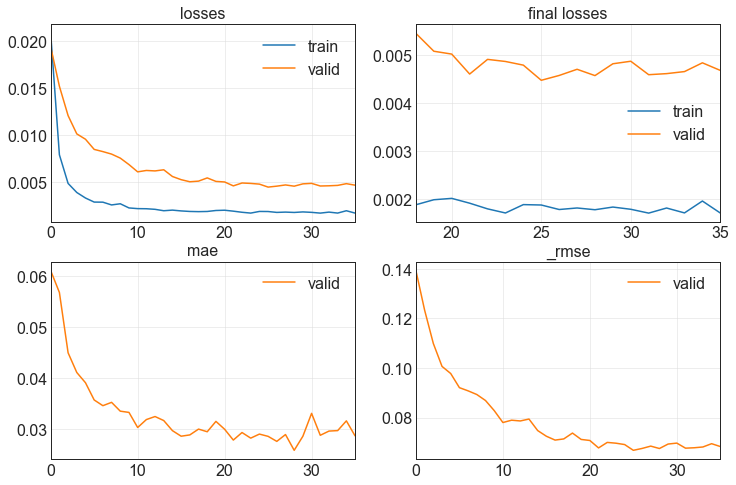

188.39056539535522                                                                                                     
[0.0017049092566594481, 0.004676986485719681, 0.028618967160582542, 0.06838849931955338]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 82%|██████████████████████████████████▍       | 82/100 [2:52:03<42:31, 141.73s/trial, best loss: 0.004676986485719681]

No improvement since epoch 20: early stopping                                                                          
 82%|██████████████████████████████████▍       | 82/100 [2:54:43<42:31, 141.73s/trial, best loss: 0.004676986485719681]

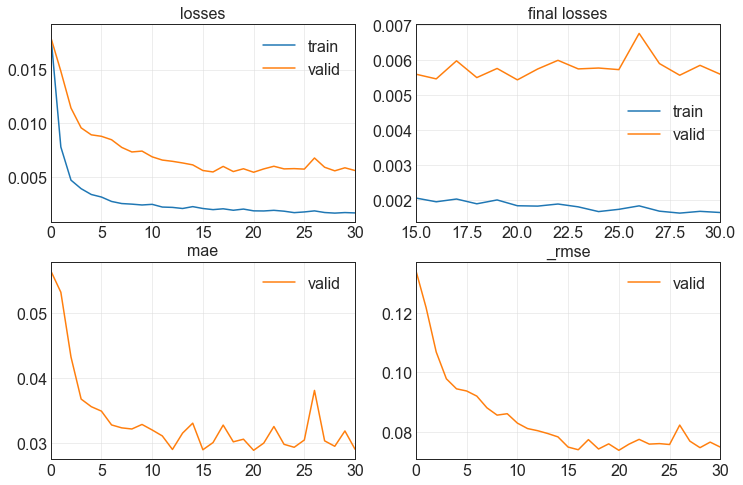

160.76740765571594                                                                                                     
[0.001652357168495655, 0.005601836834102869, 0.029117805883288383, 0.07484541833400726]                                
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 83%|██████████████████████████████████▊       | 83/100 [2:54:45<41:54, 147.90s/trial, best loss: 0.004676986485719681]

No improvement since epoch 54: early stopping                                                                          
 83%|██████████████████████████████████▊       | 83/100 [3:03:42<41:54, 147.90s/trial, best loss: 0.004676986485719681]

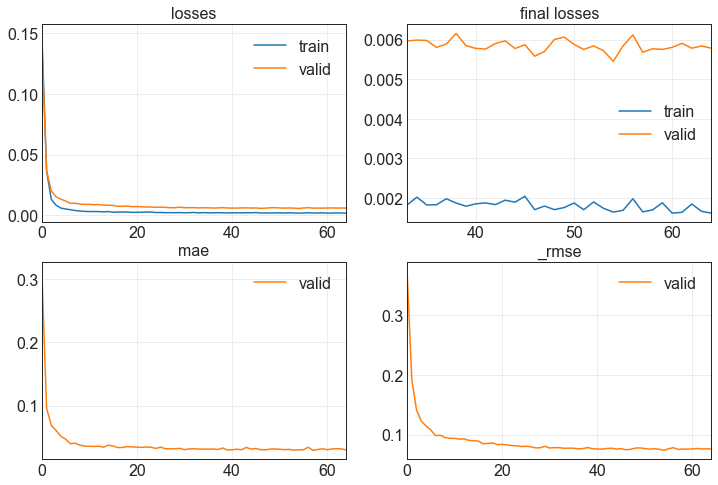

537.5378158092499                                                                                                      
[0.001615706947632134, 0.005780678708106279, 0.029942236840724945, 0.07603078335523605]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 84%|█████████████████████████████████▌      | 84/100 [3:03:44<1:10:43, 265.24s/trial, best loss: 0.004676986485719681]

No improvement since epoch 10: early stopping                                                                          
 84%|█████████████████████████████████▌      | 84/100 [3:05:05<1:10:43, 265.24s/trial, best loss: 0.004676986485719681]

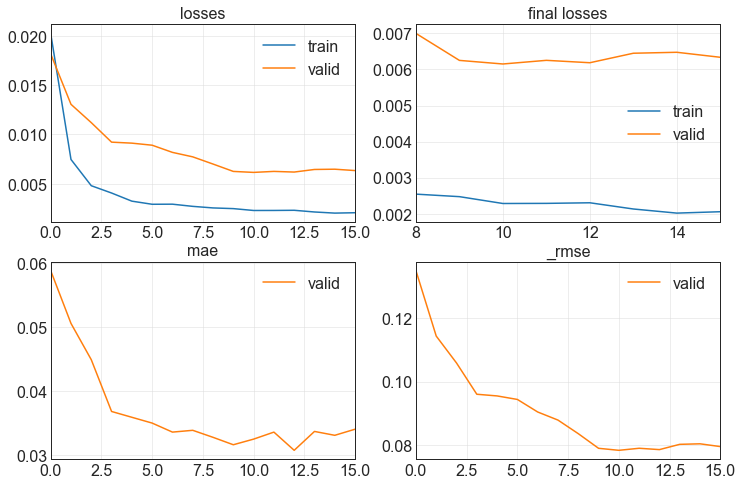

81.97671914100647                                                                                                      
[0.0020572084467858076, 0.006336933933198452, 0.03406774252653122, 0.0796048492193222]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 85%|███████████████████████████████████▋      | 85/100 [3:05:07<52:40, 210.71s/trial, best loss: 0.004676986485719681]

No improvement since epoch 31: early stopping                                                                          
 85%|███████████████████████████████████▋      | 85/100 [3:06:07<52:40, 210.71s/trial, best loss: 0.004676986485719681]

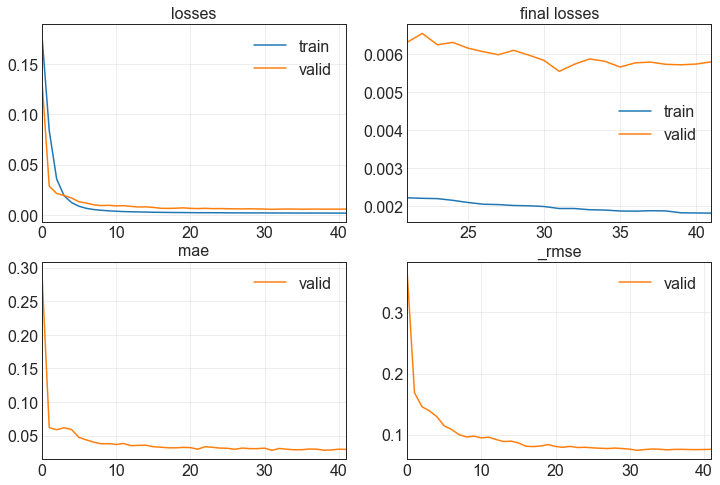

59.66979908943176                                                                                                      
[0.001807864522561431, 0.005797774530947208, 0.029431160539388657, 0.07614311575889587]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 86%|████████████████████████████████████      | 86/100 [3:06:08<38:41, 165.83s/trial, best loss: 0.004676986485719681]

No improvement since epoch 59: early stopping                                                                          
 86%|████████████████████████████████████      | 86/100 [3:12:05<38:41, 165.83s/trial, best loss: 0.004676986485719681]

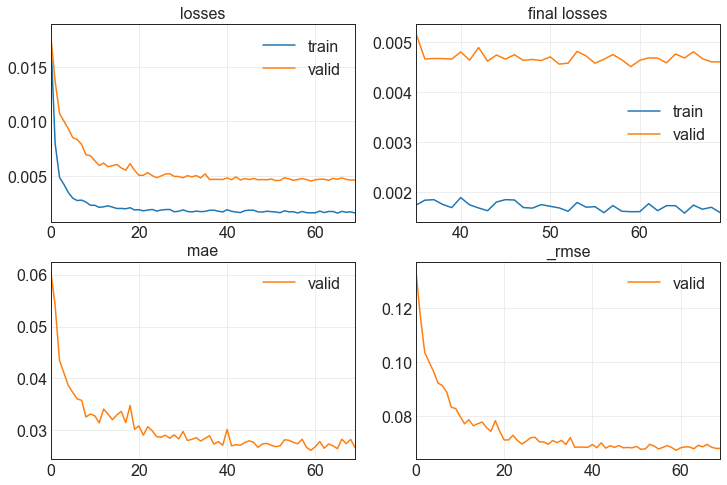

356.80372977256775                                                                                                     
[0.0015876942779868841, 0.004606243688613176, 0.026640092954039574, 0.06786931306123734]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 87%|████████████████████████████████████▌     | 87/100 [3:12:07<48:26, 223.56s/trial, best loss: 0.004606243688613176]

No improvement since epoch 13: early stopping                                                                          
 87%|████████████████████████████████████▌     | 87/100 [3:13:45<48:26, 223.56s/trial, best loss: 0.004606243688613176]

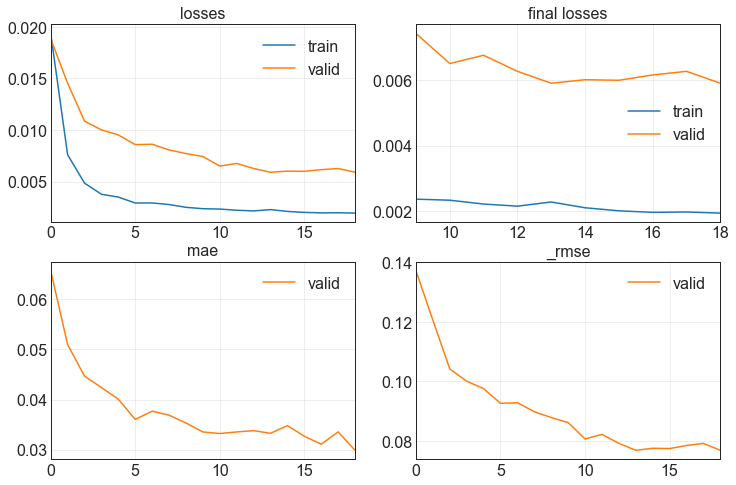

98.72369718551636                                                                                                      
[0.001940405578352511, 0.005903591867536306, 0.02988019399344921, 0.07683482766151428]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 88%|████████████████████████████████████▉     | 88/100 [3:13:47<37:18, 186.55s/trial, best loss: 0.004606243688613176]

No improvement since epoch 25: early stopping                                                                          
 88%|████████████████████████████████████▉     | 88/100 [3:14:47<37:18, 186.55s/trial, best loss: 0.004606243688613176]

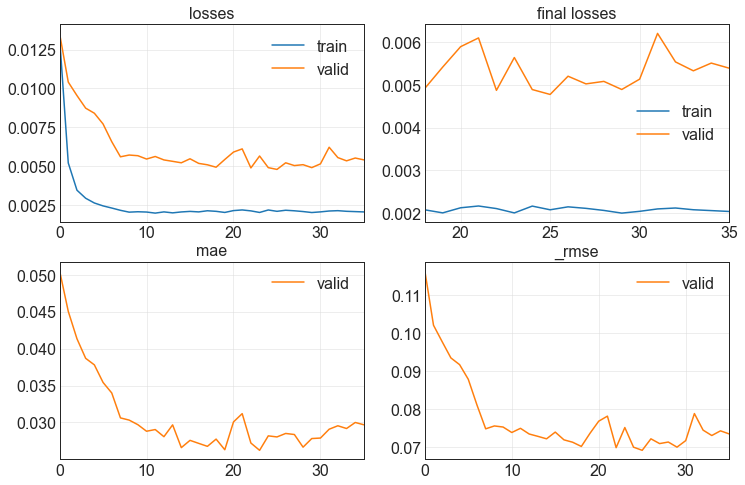

60.27729320526123                                                                                                      
[0.0020385640673339367, 0.0053911213763058186, 0.02968294732272625, 0.07342426478862762]                               
Trying params:                                                                                                         
{'batch_size': 16, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 89%|█████████████████████████████████████▍    | 89/100 [3:14:49<27:20, 149.11s/trial, best loss: 0.004606243688613176]

No improvement since epoch 74: early stopping                                                                          
 89%|█████████████████████████████████████▍    | 89/100 [3:29:25<27:20, 149.11s/trial, best loss: 0.004606243688613176]

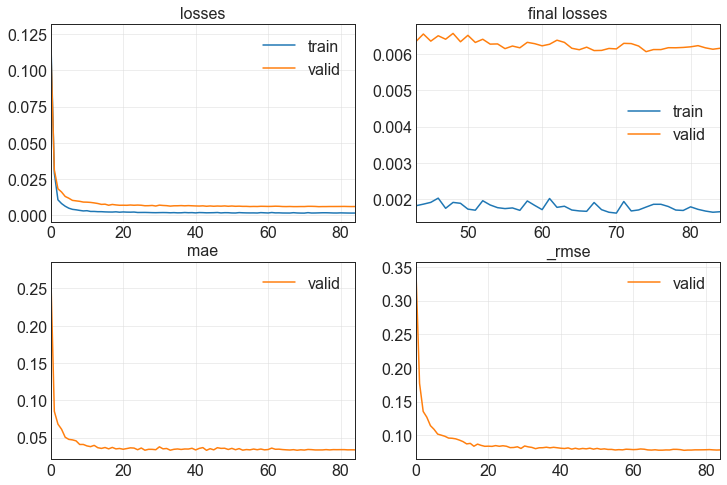

877.2717258930206                                                                                                      
[0.0016591498861089349, 0.006156072486191988, 0.0334833562374115, 0.07846064865589142]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 90%|████████████████████████████████████    | 90/100 [3:29:27<1:01:19, 367.99s/trial, best loss: 0.004606243688613176]

No improvement since epoch 32: early stopping                                                                          
 90%|████████████████████████████████████    | 90/100 [3:32:07<1:01:19, 367.99s/trial, best loss: 0.004606243688613176]

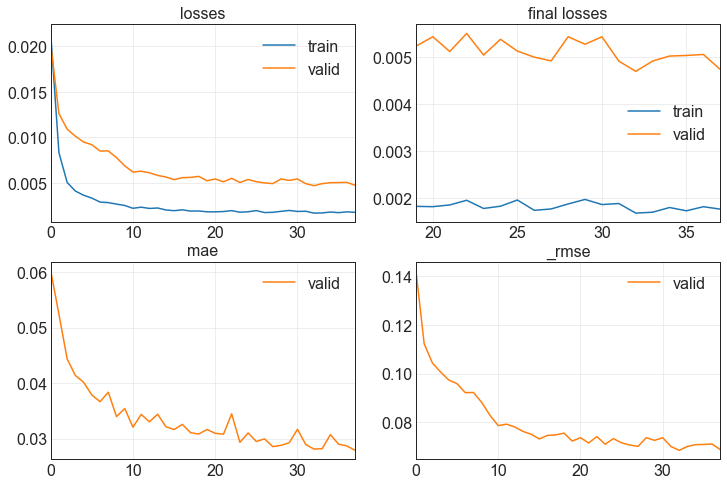

159.55901050567627                                                                                                     
[0.001762372674420476, 0.004732328932732344, 0.027871351689100266, 0.06879191845655441]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 91%|██████████████████████████████████████▏   | 91/100 [3:32:08<45:53, 305.91s/trial, best loss: 0.004606243688613176]

No improvement since epoch 29: early stopping                                                                          
 91%|██████████████████████████████████████▏   | 91/100 [3:34:54<45:53, 305.91s/trial, best loss: 0.004606243688613176]

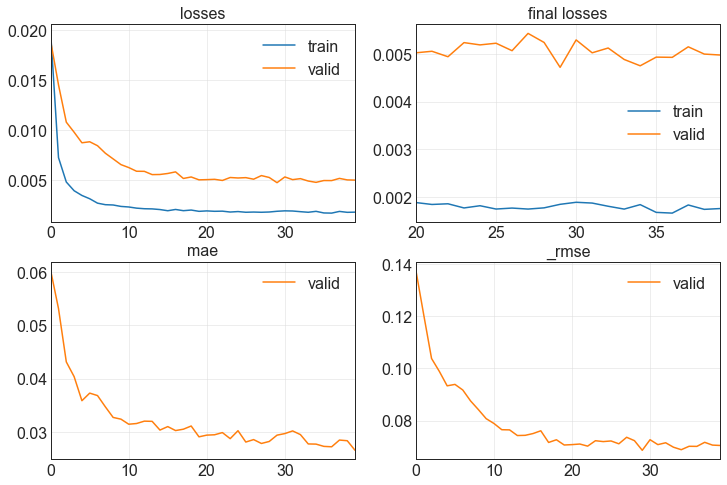

165.9152798652649                                                                                                      
[0.0017615434480831027, 0.004973587580025196, 0.026548275724053383, 0.07052367180585861]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 92%|██████████████████████████████████████▋   | 92/100 [3:34:56<35:14, 264.35s/trial, best loss: 0.004606243688613176]

No improvement since epoch 27: early stopping                                                                          
 92%|██████████████████████████████████████▋   | 92/100 [3:37:36<35:14, 264.35s/trial, best loss: 0.004606243688613176]

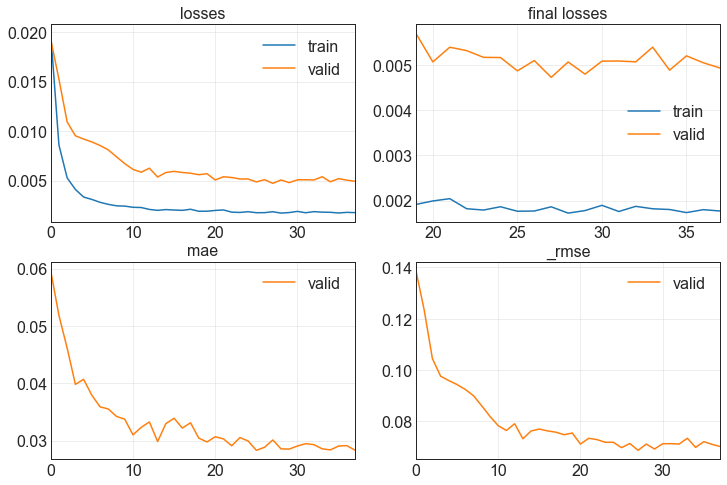

160.5593044757843                                                                                                      
[0.0017689346568658948, 0.004930954892188311, 0.028331521898508072, 0.07022075355052948]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 93%|███████████████████████████████████████   | 93/100 [3:37:38<27:15, 233.66s/trial, best loss: 0.004606243688613176]

No improvement since epoch 9: early stopping                                                                           
 93%|███████████████████████████████████████   | 93/100 [3:38:40<27:15, 233.66s/trial, best loss: 0.004606243688613176]

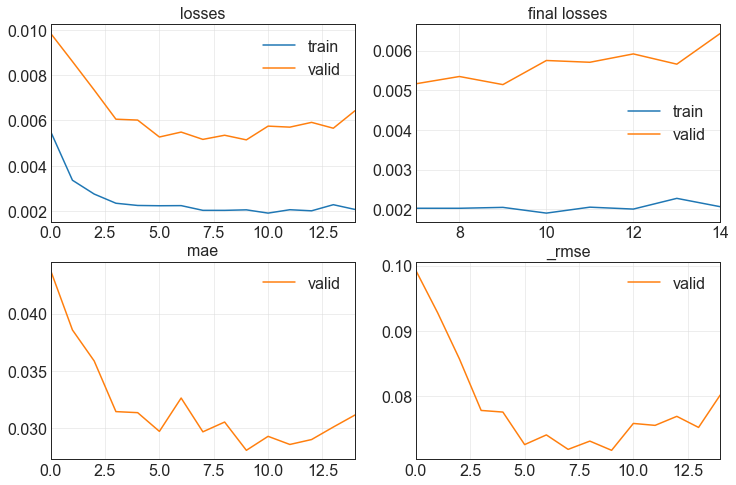

62.626978158950806                                                                                                     
[0.002068224363029003, 0.0064311521127820015, 0.031137913465499878, 0.08019445836544037]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 94%|███████████████████████████████████████▍  | 94/100 [3:38:42<18:16, 182.79s/trial, best loss: 0.004606243688613176]

No improvement since epoch 22: early stopping                                                                          
 94%|███████████████████████████████████████▍  | 94/100 [3:40:58<18:16, 182.79s/trial, best loss: 0.004606243688613176]

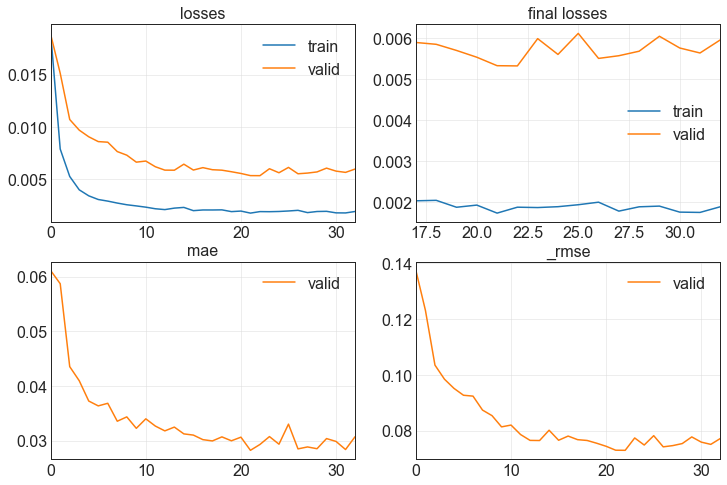

136.8408064842224                                                                                                      
[0.0018871218198910356, 0.005953507963567972, 0.030709106475114822, 0.07715898007154465]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 95%|███████████████████████████████████████▉  | 95/100 [3:41:00<14:07, 169.45s/trial, best loss: 0.004606243688613176]

No improvement since epoch 57: early stopping                                                                          
 95%|███████████████████████████████████████▉  | 95/100 [3:45:36<14:07, 169.45s/trial, best loss: 0.004606243688613176]

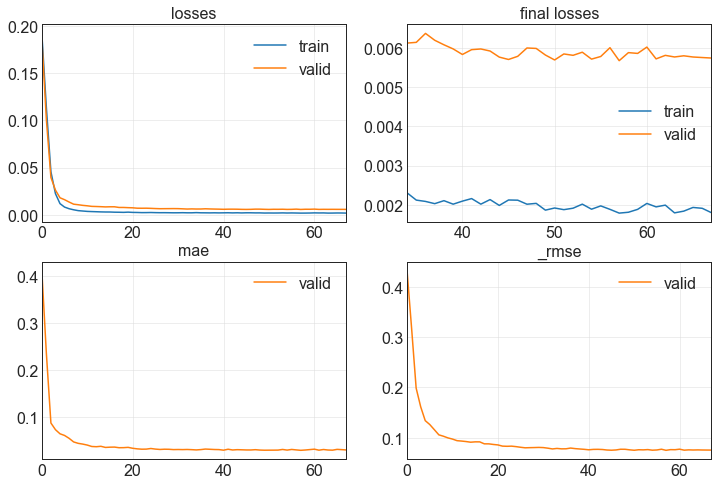

275.623907327652                                                                                                       
[0.0018049887148663402, 0.0057396674528717995, 0.030370093882083893, 0.07576059550046921]                              
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 96%|████████████████████████████████████████▎ | 96/100 [3:45:37<13:26, 201.74s/trial, best loss: 0.004606243688613176]

No improvement since epoch 40: early stopping                                                                          
 96%|████████████████████████████████████████▎ | 96/100 [3:49:04<13:26, 201.74s/trial, best loss: 0.004606243688613176]

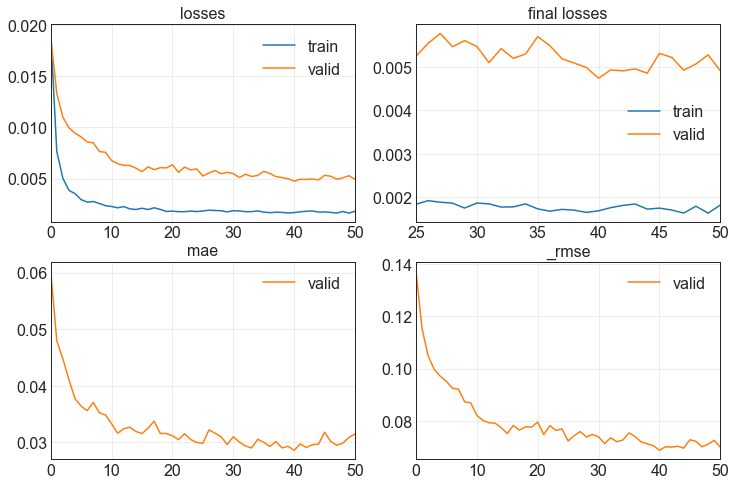

207.0879306793213                                                                                                      
[0.0018142166081815958, 0.00491816271096468, 0.031476862728595734, 0.07012961059808731]                                
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 97%|████████████████████████████████████████▋ | 97/100 [3:49:06<10:11, 203.79s/trial, best loss: 0.004606243688613176]

No improvement since epoch 17: early stopping                                                                          
 97%|████████████████████████████████████████▋ | 97/100 [3:50:40<10:11, 203.79s/trial, best loss: 0.004606243688613176]

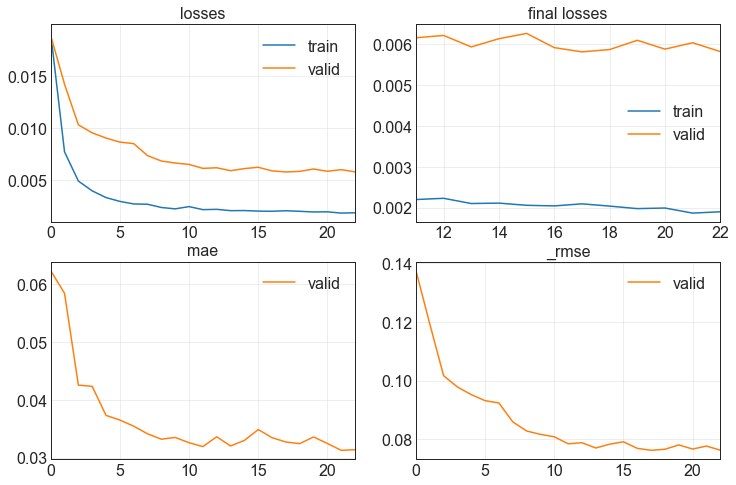

94.87698435783386                                                                                                      
[0.0018990052631124854, 0.005818508565425873, 0.03136151283979416, 0.0762791559100151]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}
TCN                                                                                                                    
 98%|█████████████████████████████████████████▏| 98/100 [3:50:42<05:43, 171.56s/trial, best loss: 0.004606243688613176]

No improvement since epoch 52: early stopping                                                                          
 98%|█████████████████████████████████████████▏| 98/100 [3:55:05<05:43, 171.56s/trial, best loss: 0.004606243688613176]

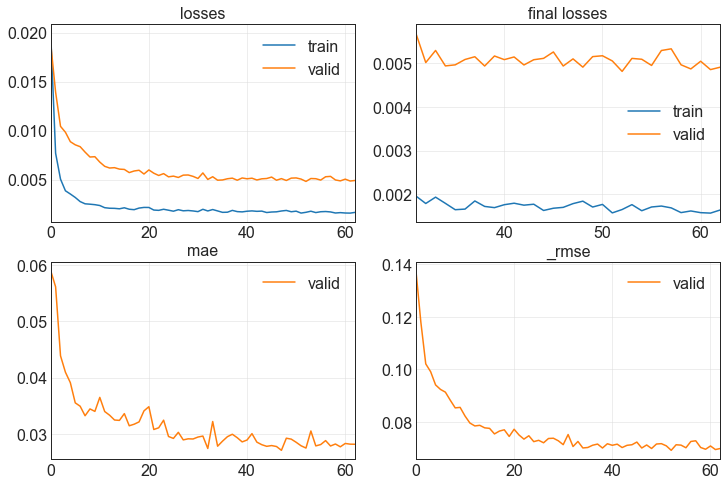

262.9687159061432                                                                                                      
[0.0016463547945022583, 0.004904864821583033, 0.028145642951130867, 0.07003474980592728]                               
Trying params:                                                                                                         
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 5}
TCN                                                                                                                    
 99%|█████████████████████████████████████████▌| 99/100 [3:55:07<03:19, 199.43s/trial, best loss: 0.004606243688613176]

No improvement since epoch 12: early stopping                                                                          
 99%|█████████████████████████████████████████▌| 99/100 [3:56:21<03:19, 199.43s/trial, best loss: 0.004606243688613176]

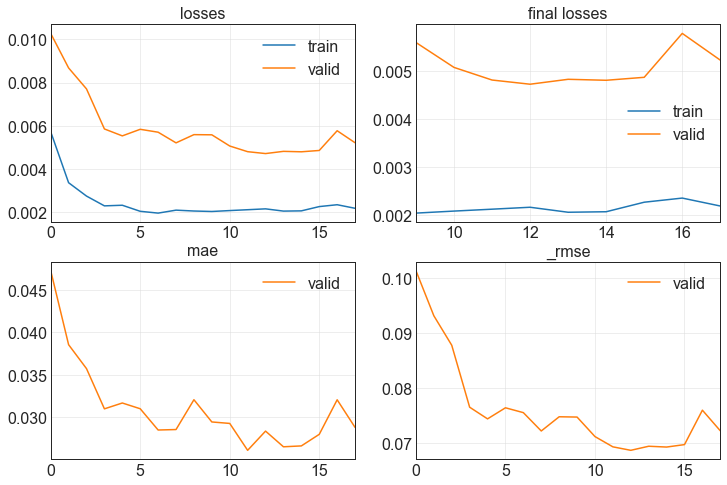

74.99855661392212                                                                                                      
[0.0021876308601349592, 0.005220682825893164, 0.02879350818693638, 0.07225429266691208]                                
100%|█████████████████████████████████████████| 100/100 [3:56:22<00:00, 141.82s/trial, best loss: 0.004606243688613176]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 32, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x0000020A44E56438>, 'patience': 10}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(8606, 529, 10)

In [62]:
y.shape

(8606, 529)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = TCN
k = {
    'layers': params['layers'],
    'ks': params['ks'],
    'conv_dropout': params['conv_dropout']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

TCN


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): TCN(
    (tcn): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(529, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.5, inplace=False)
        (conv2): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.5, inplace=False)
        (net): Sequential(
          (0): Conv1d(529, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.5, inplace=False)
          (4): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding=(6,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.5, inplace=False)
        )
        (downsample): Conv1d(529, 25, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(25, 25, kernel_size=(7,), stride=(1,), padding

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

186,004 total parameters.
186,004 training parameters.


Training the model:

No improvement since epoch 35: early stopping


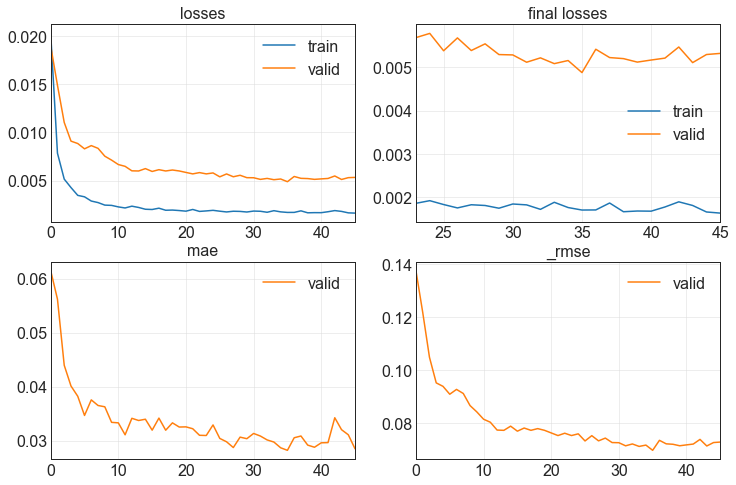

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

2153


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0021, 0.0735, 0.0538,  ..., 0.0027, 0.0017, 0.0017],
         [0.0021, 0.0723, 0.0526,  ..., 0.0026, 0.0016, 0.0017],
         [0.0020, 0.0718, 0.0511,  ..., 0.0025, 0.0016, 0.0016],
         ...,
         [0.0047, 0.0427, 0.0460,  ..., 0.0059, 0.0037, 0.0033],
         [0.0046, 0.0419, 0.0470,  ..., 0.0058, 0.0036, 0.0033],
         [0.0045, 0.0412, 0.0477,  ..., 0.0057, 0.0035, 0.0032]]),
 tensor([[0.0000e+00, 4.2537e-04, 9.6929e-04,  ..., 4.5983e-04, 1.2533e-04,
          0.0000e+00],
         [0.0000e+00, 1.6241e-04, 3.8517e-04,  ..., 5.4193e-04, 8.0880e-05,
          0.0000e+00],
         [0.0000e+00, 2.2912e-04, 1.9301e-03,  ..., 4.0765e-04, 1.9965e-04,
          0.0000e+00],
         ...,
         [0.0000e+00, 4.7334e-03, 0.0000e+00,  ..., 1.2775e-03, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 6.2943e-03, 0.0000e+00,  ..., 1.1132e-03, 2.1495e-04,
          0.0000e+00],
         [0.0000e+00, 1.3714e-02, 0.0000e+00,  ..., 1.7625e-04, 0.0000e+00,
         

In [73]:
test_targets.shape

torch.Size([2153, 529])

In [74]:
test_preds.shape

torch.Size([2153, 529])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(2153, 1, 529)

In [78]:
y_pred.shape

(2153, 1, 529)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(2153, 1, 529)

In [83]:
y_pred.shape

(2153, 1, 529)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  243.55520367622375
Test time (in seconds):  0.6479778289794922


In [92]:
print('Training time (in seconds) per epoch: ', 243.55520367622375 / 46)

Training time (in seconds) per epoch:  5.294678340787473


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  20.1735045411595
MAE:  6.846049822137216


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

TCN_TM-minmax_RMSE-10-1-step-1.pdf
TCN_TM-minmax_MAE-10-1-step-1.pdf


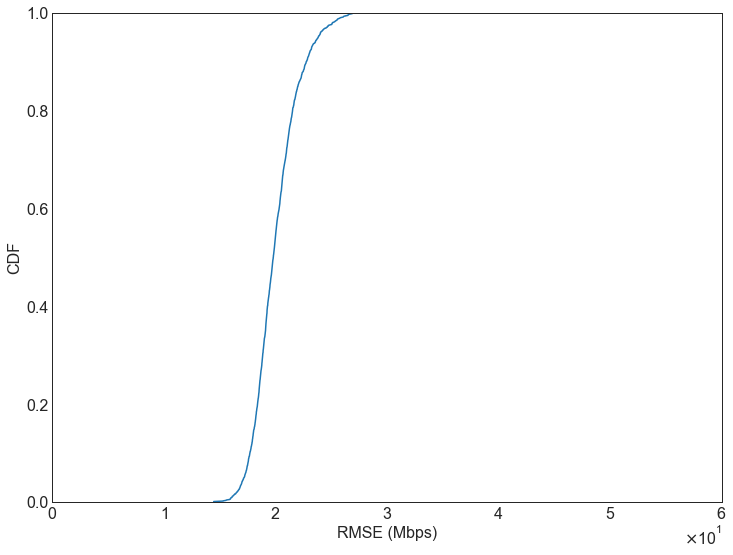

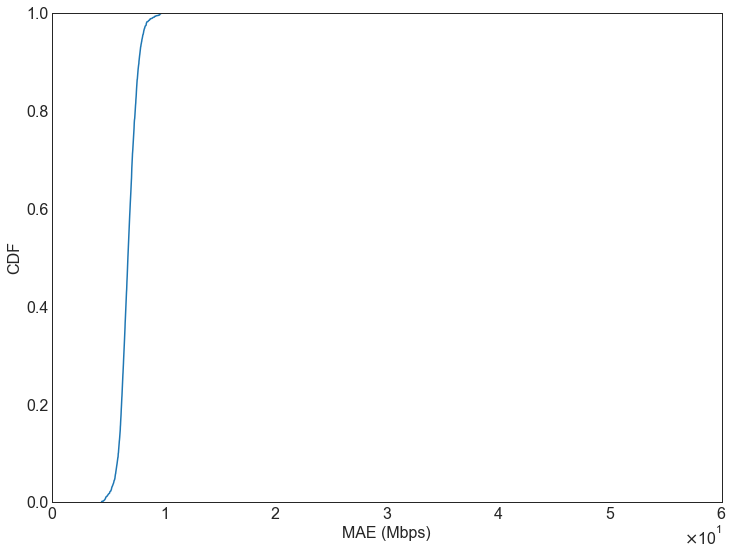

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)